# Get Metadata

In [2]:
import json
metadata_file_path = 'results_metadata.json'
with open(metadata_file_path, 'r') as file:
    # Load the JSON data from the file into a Python dictionary
    metadata = json.load(file)

metadata

{'boolq_valid': {'fields': ['Reasoning', 'Answer', 'Confidence'],
  'models': {'gpt-4o': {'file_id': 'file-12Pr3mz95PN2sGpZnCioLh',
    'batch_id': 'batch_6882b9e8c0b88190a6078d1259b0bbac',
    'output_filename': 'boolq_valid_gpt-4o.jsonl',
    'old_batch': 'batch_68885a713de48190b5c616795507d7f4'},
   'claude-3-haiku-20240307': {'file_id': 'boolq_valid',
    'batch_id': 'msgbatch_01Eik9sN8Ek6cBd9haYdQoD9',
    'output_filename': 'boolq_valid_claude-3-haiku-20240307.jsonl'},
   'gemini-2.5-pro': {'file_id': 'none',
    'batch_id': 'batches/40v60ylnpg26z17kst8c2tjbpb5lmrhn9rrf',
    'output_filename': 'boolq_valid_gemini-2.5-pro.json'},
   'claude-3-7-sonnet-20250219': {'file_id': 'boolq_valid',
    'batch_id': 'msgbatch_012oL94fp2HXhvcxAq4Z1BqR',
    'output_filename': 'boolq_valid_claude-3-7-sonnet-20250219.jsonl'},
   'gemini-2.5-flash': {'file_id': 'none',
    'batch_id': 'batches/b6oo1vivedngmdlk1ahnluu326o9x81b9vci',
    'output_filename': 'boolq_valid_gemini-2.5-flash.json'},
   

# Retrieve Batch Responses

In [2]:
%pip install -q -U "google-genai>=1.0.0"

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
from google import genai
from google.genai import types

key = os.getenv("GOOGLE_API_KEY")
client = genai.Client(api_key=key,http_options={'api_version': 'v1alpha'})

### Save Results

In [ ]:
def save_job_content(batch_job, model_name, dataset_name):
    if batch_job.state.name == 'JOB_STATE_SUCCEEDED':
        result_file_name = batch_job.dest.file_name
        print(f"         Results are in file: {result_file_name}")

        print("         Downloading and saving result file content...")
        file_content_bytes = client.files.download(file=result_file_name)
        file_content = file_content_bytes.decode('utf-8')

        # Create model-specific folder
        folder_name = 'Raw Results/Gemini/' + model_name #.replace(".", "-")
        os.makedirs(folder_name, exist_ok=True)
        
        # Define save path
        save_path = os.path.join(folder_name, f"{dataset_name}_{model_name}.json")

        # Parse JSONL into a list of objects
        all_results = []
        for line in file_content.splitlines():
            if line:
                parsed_response = json.loads(line)
                all_results.append(parsed_response)

        # Save as JSON
        with open(save_path, "w") as f:
            json.dump(all_results, f, indent=2)

        print(f"        ✅ Saved results to {save_path}")

    else:
        print(f"Job did not succeed. Final state: {batch_job.state.name}")


## ChatGPT

### Initialize

In [6]:
%pip install -U openai

Defaulting to user installation because normal site-packages is not writeable
  Using cached openai-1.99.9-py3-none-any.whl.metadata (29 kB)
Using cached openai-1.99.9-py3-none-any.whl (786 kB)
  Attempting uninstall: openai
    Found existing installation: openai 1.95.1
    Uninstalling openai-1.95.1:
      Successfully uninstalled openai-1.95.1
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Noam Michael\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [564]:
from openai import OpenAI
import os
key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key = key)

### Get Responses

In [565]:
def save_job_content(batch_job, model_name, dataset_name):
    folder_name = 'Raw Results/GPT/' + model_name.replace(".", "-")
    os.makedirs(folder_name, exist_ok=True)
    status = batch_job.status
    print(f'    Batch Status: {status}')
    
    if status == 'completed':
        
        output_file_id = batch_job.output_file_id
        resp = client.files.content(output_file_id)
        text = getattr(resp, "text", None) or resp.content.decode("utf-8")
        print(f'        OutputFile ID: {output_file_id}')

        # Save output as a JSONL
        file_name = f"{dataset_name}_{model_name}.jsonl"
        save_path = os.path.join(folder_name, file_name)
        with open(save_path, "w", encoding="utf-8") as f:
            f.write(text if text.endswith("\n") else text + "\n")
    else:
        print(f"Job did not succeed. Final state: {status}")
    


In [566]:
openai_models = ["o3-2025-04-16"]

for dataset_name, dataset_info in metadata.items():

    model_info = dataset_info['models']
    print(f"{dataset_name}:")
    
    for model_name, model_data in model_info.items():

        if model_name in openai_models:

            model_batch = model_data['batch_id']
            print(f'    {model_name}:   {model_batch}')

            batch = client.batches.retrieve(model_batch)
            save_job_content(batch, model_name, dataset_name)
            key = f"{dataset_name}_{model_name}.jsonl"
            model_info[model_name]['output_filename'] = key
    print()

boolq_valid:
    o3-2025-04-16:   batch_689c1b3dd84c8190b4c64a5a528568f2
    Batch Status: completed
        OutputFile ID: file-1L1Zt7HWYnK3V69BvJAHpr

lsat_ar_test:
    o3-2025-04-16:   batch_68a51081d7c081908c832f6fbf8521cd
    Batch Status: completed
        OutputFile ID: file-FXgiMSnDor3rxXTHPPTSY9

sciq_test:
    o3-2025-04-16:   batch_689c1b4514f0819082524f649646fed7
    Batch Status: completed
        OutputFile ID: file-GPSgt2nYfW6UpGZqgvYP1i

life_eval:
    o3-2025-04-16:   batch_689c1b40e46081909918068e373659db
    Batch Status: completed
        OutputFile ID: file-C7KLrkkKHGE6wNZevHjV9X

halu_eval_qa:
    o3-2025-04-16:   batch_68a510805af88190b6e552898bac2c77
    Batch Status: completed
        OutputFile ID: file-MEFyspqx4HYWipdpv2h98u

sat_en:
    o3-2025-04-16:   batch_689c1b43a6308190ac30adb563dd51f0
    Batch Status: completed
        OutputFile ID: file-HLcTkwzAafE93jDMcSt36w



In [10]:
## Update results_metadata.json
file_path = 'results_metadata.json'
with open(file_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

## Claude

### Initialize

In [ ]:
%pip install -U pip -U Anthropic

In [214]:
import anthropic
from anthropic import Anthropic, AsyncAnthropic, APIError

key = os.getenv("ANTHROPIC_API_KEY")
client = Anthropic(api_key = key)

### Get Responses

In [215]:
def save_claude_batch_jsonl(batch_id, model_name, dataset_name):
    folder_name = os.path.join("Raw Results", "Claude", model_name.replace(".", "-"))
    os.makedirs(folder_name, exist_ok=True)

    save_path = os.path.join(folder_name, f"{dataset_name}_{model_name}.jsonl")

    with open(save_path, "w", encoding="utf-8") as f:
        for result in client.messages.batches.results(batch_id):
            # Convert object to dict so it’s JSON serializable
            result_dict = result.model_dump()  # anthropic SDK uses Pydantic-like models
            f.write(json.dumps(result_dict) + "\n")

    print(f"✅ Saved Claude batch results to {save_path}")

In [216]:
claude_models = ['claude-3-haiku-20240307', 'claude-3-7-sonnet-20250219', "claude-sonnet-4-20250514"]

for dataset_name, dataset_info in metadata.items():

    model_info = dataset_info['models']
    print(f"{dataset_name}:")
    
    for model_name, model_data in model_info.items():

        if model_name in claude_models:

            batch_id = model_data['batch_id']
            print(f'    {model_name}:   {batch_id}')
            save_claude_batch_jsonl(batch_id, model_name, dataset_name)
            key = f"{dataset_name}_{model_name}.jsonl"
            model_info[model_name]['output_filename'] = key
    print()

boolq_valid:
    claude-3-haiku-20240307:   msgbatch_01Eik9sN8Ek6cBd9haYdQoD9
✅ Saved Claude batch results to Raw Results\Claude\claude-3-haiku-20240307\boolq_valid_claude-3-haiku-20240307.jsonl
    claude-3-7-sonnet-20250219:   msgbatch_012oL94fp2HXhvcxAq4Z1BqR
✅ Saved Claude batch results to Raw Results\Claude\claude-3-7-sonnet-20250219\boolq_valid_claude-3-7-sonnet-20250219.jsonl
    claude-sonnet-4-20250514:   msgbatch_01UdsJtGrwuHrV9xv7kUPwVo
✅ Saved Claude batch results to Raw Results\Claude\claude-sonnet-4-20250514\boolq_valid_claude-sonnet-4-20250514.jsonl

lsat_ar_test:
    claude-3-7-sonnet-20250219:   msgbatch_01Cc7X22iDyC3bWrK3ZxaJaS
✅ Saved Claude batch results to Raw Results\Claude\claude-3-7-sonnet-20250219\lsat_ar_test_claude-3-7-sonnet-20250219.jsonl
    claude-3-haiku-20240307:   msgbatch_011VWy4skZeUZ5o3HcLG7hTJ
✅ Saved Claude batch results to Raw Results\Claude\claude-3-haiku-20240307\lsat_ar_test_claude-3-haiku-20240307.jsonl
    claude-sonnet-4-20250514:   msgbatc

In [ ]:
## Update results_metadata.json
with open(metadata_file_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)



# Parse Everything

In [ ]:
import json5
import re
import pandas as pd
import numpy as np
import ast
import unicodedata
import re



def quick_parse(s):
    
    
    try:
        input = re.findall(r"\{.*?\}", s, flags=re.DOTALL)[0]
        my_dict = str(ast.literal_eval(input))

        return json5.loads(my_dict) # Had to combine both ast and json5 to finally get it to work right
        
    except:
        return {}


# --- Universal parser ---
def parse_response(entries, fields, model_type = None, stats= True): 
    data = {field: [] for field in fields}
    parsed_list = []
    #content_list = []

    for entry in entries:
        content = fix_reasoning_quotes(entry)
        #content_list.append(content)
        content_dict = quick_parse(content)
        for field in fields:
            try:
                data[field].append(content_dict[field])
            except:
                data[field].append(None)
        

    df = pd.DataFrame(data=data)
    df["coerce"] = df.notna().any(axis=1)
    df['content'] = entries

    if model_type:
        df = special_parser(df, model_type)

    #df['coerce'] = parsed_list
    #df['content'] = content_list

    return df

def llama_get_token_dict(answers, # A series of answers
                         outputs,   # A series of all json lines
                         contents   #A series of all the relavent content 
                         ):
    
    global data
    data = pd.DataFrame(
        {
            'Answer': answers,
            'Output': outputs,
            'Content': contents
        }
    )

    token_dict_list = []
    token_pos_list = []

    for idx, row in data.iterrows():
        answer = row['Answer']
        content = row['Content']
        entry = row['Output']
        if answer == None:
            token_dict_list.append(None)
            token_pos_list.append(None)
            continue

        if isinstance(answer, str):
            pattern = r'"(' + re.escape(answer) + r')"'
        else:
            pattern = r'(' + re.escape(str(answer).replace('.0', '')) + r')'


        match = re.search(pattern, content)

        answer_index = content.find(str(answer))
        if match is None:
            token_dict_list.append({})
            token_pos_list.append(-1)
            continue

        #print(content) #


        answer_index = match.start() #+ 1

        #print(f'Answer: {answer:<10} | Answer Index: {answer_index}')
        # Find Token 
        position = 0

        # Find answer token in JSON
        position = 0
        response = ""
        while len(response) < answer_index:
            token = entry['ouput']['tokens'][position]['top_token'] 
            response += token 
            position += 1 


        if token.strip() == answer:
            token_dict = entry['ouput']['tokens'][position - 1]['top_100']
            token_dict_list.append(token_dict)
            token_pos_list.append(position - 1)

        
        else:
            token_dict = entry['ouput']['tokens'][position ]['top_100']
            token_dict_list.append(token_dict)
            token_pos_list.append(position)

        if token_pos_list == None:
            token_pos_list = [0] * len(token_dict_list)
    return token_dict_list, token_pos_list

def get_content(output, model_type:str) -> list:
    content = []
    qid_list = []
    i = 0
    for entry in output:
        try:
            if model_type == "GPT":
                qid_list.append(entry['custom_id'])  
                content.append(entry['response']['body']['choices'][0]['message']['content'])
            if model_type == "Gemini":
                qid_list.append(entry['key'])
                content.append(entry['response']['candidates'][0]['content']['parts'][0]['text'])
            if model_type == "Claude":
                qid_list.append(entry['custom_id'])
                content.append(entry['result']['message']['content'][0]['text'])
            if model_type == "Llama":
                qid_list.append(entry["qid"])
                content.append(entry["ouput"]["content"].replace('<|eot_id|>', ''))  #I misspelled 'output' just keep in mind when debugging
    
                # --- Get token #
                
                
        except:
            content.append("GENERATION FAILED")

    return content, qid_list

def special_parser(df, model_name):                               # --- To do 
    pass



def read_json_lines(file_path):
    # Load all lines from the file
    entries = []
    skiped_lines = 0
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            try:
                entries.append(json.loads(line))
            except:
                skiped_lines += 1
                continue

    return entries, skiped_lines


def read_json(file_path):
    # Load all lines from the file
    with open(file_path, "r") as f:
        entries = json.load(f)
    return entries, 0

def fix_reasoning_quotes(s):
    # add quotes if missing
    text = s.replace('"Reasoning": The', '"Reasoning": "The')#.replace('. "Ans', '.", "Ans')

    pattern = r'("Reasoning"\s*:\s*)"([\s\S]*?)"(\s*[,\}])'

    def repl(m: re.Match) -> str:
        # m.group(2) = reasoning text
        return f'{m.group(1)}"""{m.group(2)}"""{m.group(3)}'

    return re.sub(pattern, repl, text, flags=re.DOTALL)


def field_probs(fields: list, token_dict: dict):
    if token_dict == None:
        return {f"{field}_prob": None for field in fields}
    # Step 1: collapse similar tokens (case-insensitive)
    collapsed = {}
    for token, val in token_dict.items():
        canonical = token.strip().lower()
        collapsed[canonical] = collapsed.get(canonical, 0.0) + val

    # Step 2: pick only the fields we care about
    values = {}
    for field in fields:
        canonical = str(field).strip().lower()
        values[field] = collapsed.get(canonical, 0.0)

    # Step 3: normalize to probabilities
    total = sum(values.values())
    if total == 0:
        return {f"{field}_prob": 0.0 for field in fields}

    return {f"{field}_prob": val / total for field, val in values.items()}

In [106]:
from pathlib import Path
import time
import ast

model_names = {
    # "GPT": {
    #     "gpt-4o": "GPT-4o",
    #     "o3-2025-04-16": "GPT-o3",
    # },
    # "Claude":{
    #     "claude-sonnet-4-20250514": "Claude-Sonnet-4",
    #     "claude-3-7-sonnet-20250219": "Claude-Sonnet-3.7",
    #     "claude-3-haiku-20240307": "Claude Haiku 3",
    # },
    # "Gemini":{
    #     "gemini-2.5-pro": "Gemini-2.5-Pro",
    #     "gemini-2.5-flash": "Gemini-2.5-Flash"
    # },
    "Llama":{
        "Meta-Llama-3.1-8B-Instruct": "Llama-3.1-8B",
        "Meta-Llama-3.1-70B-Instruct": "Llama-3.1-70B",
    }
}

qsets = {
    #"boolq_valid": "BoolQ",
    #"halu_eval_qa": "HaluEval",
    "life_eval": "LifeEval",
    #"lsat_ar_test": "LSAT-AR",
    #"sat_en": "SAT-EN",
    #"sciq_test": "SciQ"
}

parse_results = []
llama = False
for model_type, models in model_names.items():
    result_folder = os.path.join("Raw Results", model_type)
    print(f"{model_type}:")

    for model in models:
        print(f"    {model}")
        model_result_folder = os.path.join(result_folder, model)
        llama = "llama" in model.lower()

        for qset, qset_display in qsets.items():
            filename = f"{qset}_{model}"
            print(f"        {qset_display}:")
            fields = metadata[qset]['fields']
            
            time1 = time.time()

            if "gemini" in model:
                full_filename = filename + '.json' # GPT and Claude
                full_file_path = os.path.join(model_result_folder, full_filename)
                output, skipped_lines = read_json(full_file_path)
            else:
                full_filename = filename + '.jsonl' # GPT and Claude
                full_file_path = os.path.join(model_result_folder, full_filename)
                output, skipped_lines = read_json_lines(full_file_path)

            time2 = time.time()
            if output and skipped_lines == 0:
                print(f"            ✅{qset_display} successfully loaded from: {full_file_path} ({(time2 - time1):.3f} Seconds)")
            elif output:
                print(f"            ⚠️{qset_display} partially loaded from: {full_file_path} ({(time2 - time1):.3f} Seconds)\n\t\t\tSkipped {skipped_lines} lines")
            else:
                print(f"            ❌{qset_display} failed to load! ({(time2 - time1):.3f} Seconds)")
                continue
                

            # --- Parse it ---

            content, qid = get_content(output=output, model_type = model_type) # -- To do

            df = parse_response(entries= content, fields= fields, stats = False)


            #------------------FIX THIS-----------------------------------------------------------------------
            if 'llama' in model.lower() and qset_display != 'HaluEval':
                answers = df['Answer']

                token_dict, pos = llama_get_token_dict(answers= answers, outputs= output, contents= content)
                if qset_display == 'BoolQ':
                    fields = ['True', 'False']
                    #field_tokens = [field_probs(fields, token_dict_entry) for token_dict_entry in token_dict]
                elif qset_display == 'LifeEval':
                    fields = list(range(151))

                field_tokens = [field_probs(fields, token_dict_entry) for token_dict_entry in token_dict]
                

                field_df = pd.DataFrame(field_tokens).drop(['Reasoning_prob', 'Answer_prob', 'Confidence_prob'], axis =1,  errors="ignore")

                #df['Token Position'] = token_pos
                df = df.merge(field_df, left_index=True, right_index=True)

                
            df['Question ID'] = qid
            time3 = time.time()

            parse_rate = np.mean(df['coerce'])

            if parse_rate == 1.0:
                print(f"            ✅{qset_display}---Successfully parsed all outputs ({(time3 - time2):.3f} Seconds)")
            elif parse_rate > 0:
                print(f"            ⚠️{qset_display}---Partially parsed outputs ({(time3 - time2):.3f} Seconds)")
                print(f"                Success Rate: {parse_rate * 100:.2f}%")
            else:
                print(f"            ❌{qset_display}---Failed to parse outputs ({(time3 - time2):.3f} Seconds)")

            parse_results.append({
                                "Model": model,
                                "Question Set": qset_display,
                                "Mean Coerce": parse_rate
                            })
            
            # --- Save it ---

            save_file_path = os.path.join('Parsed Results', model_type, model, filename + '.csv' )
            Path(save_file_path).parent.mkdir(parents=True, exist_ok=True) # Make the path
            

 
            try:
                df.to_csv(save_file_path)
                print(f"            ✅{qset_display}---Saved to csv at {save_file_path}")
            except Exception as e:
                print(f"            ❌{qset_display}---Failed to upload to csv!")


results_df = pd.DataFrame(parse_results)

# Pivot so rows = model type, columns = question set
pivot_df = results_df.pivot_table(
    index="Model",
    columns="Question Set",
    values="Mean Coerce",
    aggfunc="mean"
).round(3)

display(pivot_df)


Llama:
    Meta-Llama-3.1-8B-Instruct
        LifeEval:
            ✅LifeEval successfully loaded from: Raw Results\Llama\Meta-Llama-3.1-8B-Instruct\life_eval_Meta-Llama-3.1-8B-Instruct.jsonl (13.791 Seconds)
            ⚠️LifeEval---Partially parsed outputs (7.470 Seconds)
                Success Rate: 99.01%
            ✅LifeEval---Saved to csv at Parsed Results\Llama\Meta-Llama-3.1-8B-Instruct\life_eval_Meta-Llama-3.1-8B-Instruct.csv
    Meta-Llama-3.1-70B-Instruct
        LifeEval:
            ✅LifeEval successfully loaded from: Raw Results\Llama\Meta-Llama-3.1-70B-Instruct\life_eval_Meta-Llama-3.1-70B-Instruct.jsonl (2.482 Seconds)
            ⚠️LifeEval---Partially parsed outputs (7.185 Seconds)
                Success Rate: 99.88%
            ✅LifeEval---Saved to csv at Parsed Results\Llama\Meta-Llama-3.1-70B-Instruct\life_eval_Meta-Llama-3.1-70B-Instruct.csv


Question Set,LifeEval
Model,
Meta-Llama-3.1-70B-Instruct,0.999
Meta-Llama-3.1-8B-Instruct,0.990


In [ ]:
field_tokens[0]

# Analysis

In [ ]:
%pip install matplotlib -upgrade
%pip install -U seaborn

## Parsing Info

Question Set,boolq,halu,life,lsat,sat,sciq
Model Type,,,,,,
Meta-Llama-3.1-70B-Instruct,0.996,0.980,0.999,0.917,0.985,1.000
Meta-Llama-3.1-8B-Instruct,0.991,1.000,0.990,0.830,0.985,0.997
claude-3-7-sonnet-20250219,0.999,1.000,1.000,0.996,1.000,1.000
claude-3-haiku-20240307,0.991,0.928,1.000,1.000,0.893,0.999
claude-sonnet-4-20250514,0.999,1.000,1.000,0.817,1.000,1.000
deepseek-r1,0.000,0.000,0.002,0.502,0.000,0.103
deepseek-v3,1.000,1.000,1.000,0.996,1.000,1.000
gemini-2.5-flash,0.998,1.000,1.000,0.770,1.000,1.000
gemini-2.5-pro,0.976,0.992,1.000,0.817,0.990,1.000


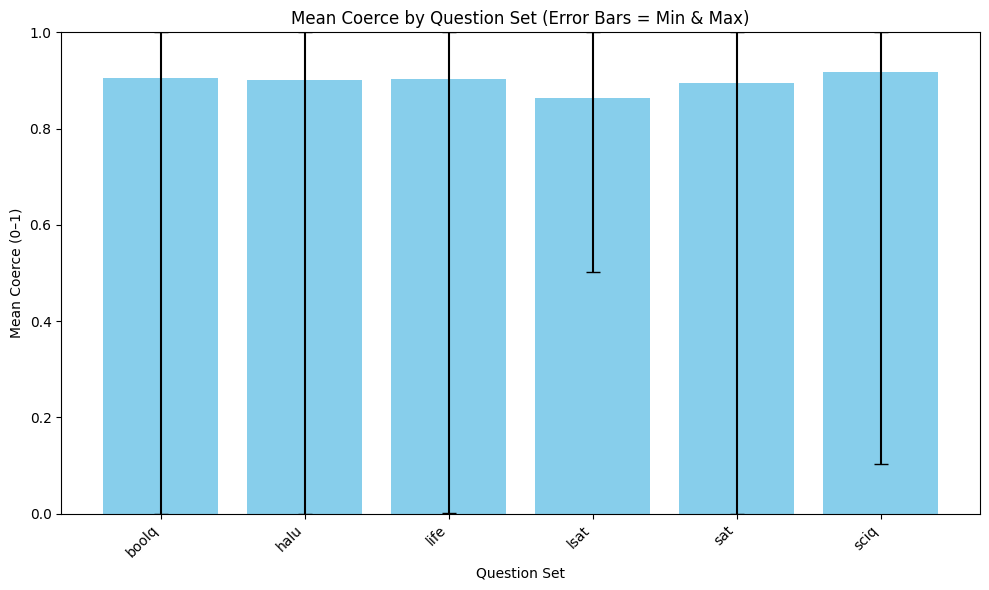

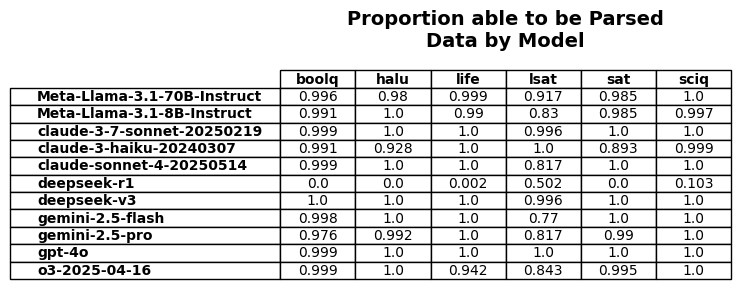

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path

base_dir = Path("Parsed Results")  # change path if needed
rows = []

for provider in base_dir.iterdir():
    if provider.is_dir():
        for model_type in provider.iterdir():
            if model_type.is_dir():
                for csv_file in model_type.glob("*.csv"):
                    fname = csv_file.stem
                    question_set = fname.split("_")[0]
                    try:

                        df = pd.read_csv(csv_file)
                        mean_val = np.mean(df['coerce']) # Drops any irrelevant columns and then sees if there are any rows with incomplete sections
                        rows.append({
                            "Model Type": model_type.name,
                            "Question Set": question_set,
                            "Mean Coerce": mean_val
                        })
                    except Exception as e:
                        print(f"Error reading {csv_file}: {e}")

results_df = pd.DataFrame(rows)

# Pivot so rows = model type, columns = question set
pivot_df = results_df.pivot_table(
    index="Model Type",
    columns="Question Set",
    values="Mean Coerce",
    aggfunc="mean"
).round(3)

display(pivot_df)
# Calculate stats per question set
means = pivot_df.mean(axis=0)
mins = pivot_df.min(axis=0)
maxs = pivot_df.max(axis=0)

# Error bar values
error_lower = means - mins
error_upper = maxs - means

plt.figure(figsize=(10, 6))
plt.bar(means.index, means.values, yerr=[error_lower, error_upper], capsize=5, color='skyblue')
plt.ylim(0, 1)
plt.ylabel("Mean Coerce (0–1)")
plt.xlabel("Question Set")
plt.title("Mean Coerce by Question Set (Error Bars = Min & Max)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Create a clean table image
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')
ax.set_title("Proportion able to be Parsed\nData by Model", fontweight='bold', fontsize=14, pad=20)
table = ax.table(
    cellText=pivot_df.round(3).values,
    colLabels=pivot_df.columns,
    rowLabels=pivot_df.index,
    cellLoc='center',
    loc='center'
)

# Styling
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Make header bold
for (row, col), cell in table.get_celld().items():
    if row == 0 or col == -1:
        cell.set_text_props(weight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# --- Fix DeepSeek naming scheme ---

rename_map = {
    "deepseek_r1": {
        "boolq_valid_processed.csv": "boolq_valid_deepseek-r1.csv",
        "halu_eval_qa_processed.csv": "halu_eval_qa_deepseek-r1.csv",
        "life_eval_deepseek-reasoner_reasoning_results_wide.csv": "life_eval_deepseek-r1.csv",
        "lsat_ar_test_processed.csv": "lsat_ar_test_deepseek-r1.csv",
        "sat_en_processed.csv": "sat_en_deepseek-r1.csv",
        "sciq_test_processed.csv": "sciq_test_deepseek-r1.csv",
    },
    "deepseek_v3": {
        "boolq_valid_deepseek-chat_results_wide.csv": "boolq_valid_deepseek-v3.csv",
        "halu_eval_qa_processed.csv": "halu_eval_qa_deepseek-v3.csv",
        "life_eval_processed.csv": "life_eval_deepseek-v3.csv",
        "lsat_ar_test_processed.csv": "lsat_ar_test_deepseek-v3.csv",
        "sat_en_processed.csv": "sat_en_deepseek-v3.csv",
        "sciq_test_processed.csv": "sciq_test_deepseek-v3.csv",
    }
}

base_dir = "Parsed Results\\Deepseek"

for subdir, files in rename_map.items():
    for old, new in files.items():
        old_path = os.path.join(base_dir, subdir, old)
        new_path = os.path.join(base_dir, subdir, new)
        if os.path.exists(old_path):
            os.rename(old_path, new_path)
            print(f"Renamed {old} -> {new}")

## Main Plots

In [5]:
# --- Function Definitions


from matplotlib.patches import Patch
import pandas as pd
import numpy as np
import seaborn as sns
import math as m

# base palettes per family
family_palettes = {
    "GPT":      sns.color_palette("Greens", 6),
    "Claude":   sns.color_palette("Blues", 6),
    "Gemini":   sns.color_palette("Purples", 6),
    "DeepSeek": sns.color_palette("Oranges", 6),
    "Llama":    sns.color_palette("RdPu", 6),
}


melted_dict = {}
# --- Function Definitions ---
def model_family(name: str) -> str:
    s = name.lower()
    if "gpt" in s or "o3" in s:   return "GPT"
    if "claude" in s:             return "Claude"
    if "gemini" in s:             return "Gemini"
    if "deepseek" in s:           return "DeepSeek"
    if "llama" in s:              return "Llama"
    return "other"


def pick_color(name: str) -> tuple:
    fam = model_family(name)
    pal = family_palettes[fam]
    s = name.lower()
    # Prefer consistent shades for common variants:
    if fam == "GPT":
        if "gpt-4o" in s: return pal[-2]  # darker green
        if "o3" in s:     return pal[1]   # lighter green
    if fam == "Claude":
        if "sonnet" in s: return pal[-2]
        if "haiku"  in s: return pal[2]
    if fam == "Gemini":
        if "pro"   in s:  return pal[-2]
        if "flash" in s:  return pal[2]
    if fam == "DeepSeek":
        if "r1"   in s:  return pal[-2]
        if "v3" in s:  return pal[2]
    return pal[3]  # default mid shade


def make_summary_plots(ece_rows, oc_rows, acc_rows, n_rows, num_used,
                       title_prefix="BoolQ", filename=None):
    # --- Build dataframes ---
    ece_df = pd.DataFrame(ece_rows, columns=["model", "ece", "family", "color"])
    oc_df  = pd.DataFrame(oc_rows,  columns=["model", "over_confidence", "family", "color"])
    acc_df = pd.DataFrame(acc_rows, columns=["model", "acc", "family", "color"])
    n_df   = pd.DataFrame(n_rows,   columns=["model", "n",   "family", "color"])

    # Establish model order from ECE (family then model)
    ece_df = ece_df.sort_values(["family", "model"]).reset_index(drop=True)
    model_order = ece_df["model"].tolist()

    # Reindex helpers to align models and carry family/color forward/backward
    def reorder(df):
        if df.empty:
            return df
        df = df.set_index("model").reindex(model_order).reset_index()
        for col in ("family", "color"):
            if col in df:
                df[col] = df[col].ffill().bfill()
        return df

    oc_df  = reorder(oc_df)
    acc_df = reorder(acc_df)
    n_df   = reorder(n_df)

    # --- Figure & axes (2 x 2) ---
    n_models = max(1, len(model_order))
    fig_w = max(12, 0.55 * n_models + 8)
    fig, axes = plt.subplots(2, 2, figsize=(fig_w, 10), sharex=False)
    axes = axes.flatten()

    # Order: top-left ECE, top-right OC, bottom-left ACC, bottom-right N
    panels = [
        (ece_df, "ece",             "ECE",             f"{title_prefix} — Expected Calibration Error by Model"),
        (oc_df,  "over_confidence", "Over Confidence", f"{title_prefix} — Overconfidence by Model"),
        (acc_df, "acc",             "Accuracy (%)",        f"{title_prefix} — Accuracy by Model"),
        (n_df,   "n",               "Count (n)",       f"{title_prefix} — Usable Rows by Model"),
    ]

    for ax, (df, val_col, y_label, title) in zip(axes, panels):
        
        x = df["model"] if not df.empty else []
        y = np.array(df[val_col]) if not df.empty else np.array([])

        ax.bar(x, y, color=(list(df["color"]) if not df.empty else None), linewidth=0, zorder = 2)
        ax.set_ylabel(y_label)
        ax.set_title(title)

        # Y-lims
        ymin = 0
        if val_col in ("ece"):
            ax.set_ylim(0, 1)
        else:
            ymax = (float(df[val_col].max()) if not df.empty else 0.0) * 1.10
            ymin = (float(df[val_col].min()) if not df.empty else 0.0) * 10 # this is a small number most of the time
            ax.set_ylim(min(0, ymin), max(1, ymax))

        # Horizontal reference line for N panel
        if val_col == "n":
            min_val = num_used
            ax.axhline(min_val, color="grey", linestyle="--", linewidth=1.5)
            ax.text(1.01, min_val, f"{min_val:.0f}", va="center", ha="left",
                    color="black", transform=plt.gca().get_yaxis_transform())

        if ymin < 0:
            ax.axhline(0, color="black", linestyle="-", linewidth=0.75) # y = 0 line for context
        # Rotate x labels
        ax.set_xticks(range(len(x)))
        ax.set_xticklabels(x, rotation=45, ha="right")
        ax.grid(zorder=0)

    # Legend from families present across all panels
    families_present = pd.concat(
        [df["family"] for df in (ece_df, oc_df, acc_df, n_df) if not df.empty],
        axis=0
    ).dropna().unique().tolist()

    legend_patches = []
    for fam in families_present:
        try:
            face = family_palettes.get(fam, None)
            if face is None:
                raise KeyError
            face = face[3]
        except Exception:
            face = "#cfcfcf"
        legend_patches.append(Patch(facecolor=face, label=fam))

    if legend_patches:
        axes[0].legend(handles=legend_patches, title="Model Families",
                       frameon=True, loc="upper left")

    fig.suptitle(f"Summary Statistics for {title_prefix}", fontsize=16, y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    # Save
    if filename is None:
        filename = f"summary_bars_{title_prefix.lower()}.png"
    out_path = output_dir / filename  # assumes output_dir exists
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    return out_path

def compute_overconfidence_mcq(df: pd.DataFrame, qset: str):
    """
    Compute mean confidence, accuracy, and overconfidence for one LLM–question set.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns ['A','B','C','D','E','Correct Answer Letter'] 
        where A–E are probabilities (floats summing to 1 per row).
    
    Returns
    -------
    dict with mean_confidence, accuracy, overconfidence
    """

    
    # Columns with option probs
    if qset == 'LSAT-AR':
        option_cols = ['A','B','C','D','E']
    else:
        option_cols = ['A','B','C','D']
    # Confidence per question = highest assigned probability
    max_probs = df[option_cols].max(axis=1)

    # For ties, find which answers are tied for max
    is_max = df[option_cols].eq(max_probs, axis=0)
    n_ties = is_max.sum(axis=1)  # number of options tied for max
    
    ## Did the correct answer get max probability?
    correct_mask = [c for c in df['Correct Answer Letter']]
    #correct_is_max = is_max.lookup(df.index, correct_mask) --- deprecated

    # Column labels of correct answers
    correct_mask = df['Correct Answer Letter']

    # Convert to numpy arrays
    rows = np.arange(len(df))
    cols = is_max.columns.get_indexer(correct_mask)

    # Get the value at (row, correct_col) for each row
    correct_is_max = is_max.to_numpy()[rows, cols]
    
    # Per-question accuracy: 1/k if correct is among ties, else 0
    per_question_acc = np.where(correct_is_max, 1/n_ties, 0)
    
    # Aggregate
    mean_conf = max_probs.mean()
    accuracy = per_question_acc.mean()
    overconf = mean_conf - accuracy
    
    return overconf

def compute_overconfidence_bool(df: pd.DataFrame):

    accuracy = np.mean(df['Correct Answer'].str.strip().str.lower() == df['Answer'].str.strip().str.lower()) # I know this is redundant I just want to make the functions similar
    conf = np.mean(df['Confidence'])

    overconf = conf - accuracy
    
    return overconf

def calibration_plot(
        scores: pd.Series, 
        confidence: pd.Series, 
        n_bins: int = 10,
        model_name: str = '',
        qset_name: str = '',
        num_complete: int = None,
        title: str = None
        ):
    # Ensure inputs are numpy arrays
    scores = scores.astype(float).to_numpy()
    #print(np.mean(scores))
    confidence = confidence.astype(float).to_numpy()
    
    # Calculate ECE and Accuracy
    ece = get_ece(pd.Series(scores), pd.Series(confidence), n_bins=n_bins)
    acc = np.mean(scores)

    melted = melt_series(score=scores, confidence=confidence)
    #display(melted)

    melted_dict[qset_name][model_name] = melted

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))

    ## Line of Well Calibration
    ax.plot([0, 1.1], [0, 1.1], linestyle='--', color='grey')

    ## Histogram:
    ax.bar(
        melted['mean_confidence'].fillna(0), 
        melted['count'].fillna(0) / melted['count'].sum(), 
        width=0.025, 
        align='center', 
        edgecolor='white',
        color = 'orange'
        )
    ax.scatter(melted['mean_confidence'], melted['mean_score'])


    ## Error Bars:
    # Standard error for a proportion
    stderr = np.sqrt((melted['mean_score'] * (1 - melted['mean_score'])) / melted['count'])
    stderr = stderr.fillna(0)  # no error if count = 0 or NaN

    ax.errorbar(melted['mean_confidence'], 
                melted['mean_score'], 
                yerr = stderr,  
                fmt='o', 
                ecolor='grey', 
                capsize=5,
                #linestyle = 'none'
                )
    
    ax.scatter(melted['mean_confidence'], melted['mean_score'], color = 'blue')


    # 45-degree reference line


    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('Stated Confidence')
    ax.set_ylabel('Average Accuracy', labelpad= 15)
    if title is not None:
        ax.set_title(f'{title}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}')
    else:
        ax.set_title(f'Calibration Plot for {model_name} on {qset_name}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}' )
    ticks = [0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7,0.7,0.8,0.9,1.0]
    labels = [0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7,0.7,0.8,0.9,1.0]
    ax.set_xticks(ticks= ticks, labels=labels)

    # Create a secondary y-axis for proportion
    ax2 = ax.twinx()
    ax.set_ylim(0, 1.1)
    ax2.set_ylabel('Proportion of Stated Confidence',rotation=-90, labelpad= 15)

    ax.set_ylim(0, 1.1)
    ax2.set_ylim(0, 1.1)
    #ax.grid(False)   # turn off grid for left axis
    #ax2.grid(False)  # turn off grid for right axis


    # --- Save Plot ---
    filename = f"cal_plot_{qset_key.lower()}_{model_key}.png"
    out_path = output_dir / "Calibration Plots"  / filename  # assumes output_dir exists
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    
    #plt.tight_layout()
    #plt.show()

    return ece, acc
    
def mcq_calibration_plot(df: pd.DataFrame,
        options: list = [],
        gold_column: str = 'Correct Answer Letter',
        answer_column: str = 'Answer',
        n_bins: int = 10,
        model_name: str = '',
        qset_name: str = '',
        num_complete: int = None,
        title: str = None,
        show = False,
        save = True
        ):
    

    # Calculate ECE and Accuracy before melting df

    summary_df =  pd.DataFrame({
        "answer": df[options].idxmax(axis=1),      # letter with max prob
        "confidence": df[options].max(axis=1)      # highest prob
    })
    summary_df['score'] = summary_df['answer'].str.lower().str.strip().str.replace('_prob', '') == df[gold_column].str.lower().str.strip()
    

    ece = get_ece(summary_df["score"], summary_df["confidence"], n_bins=n_bins)
    acc = np.mean(summary_df["score"])


    # Now melt df to get what we need for plots
    melted = df.melt(
        id_vars=['Question ID', gold_column],
        value_vars=options,
        var_name='Option',
        value_name='confidence'
        )


    melted = melted.sort_values(["Question ID", "Option"])


    #print(full_df.shape)

    melted['score'] = (melted[gold_column].str.strip() == melted['Option'].str.replace('_prob', '')).astype(int)
    
    scores = melted['score']
    confidence = melted['confidence']

    

    melted = melt_series(score=scores, confidence=confidence)
    #display(melted)

    melted_dict[qset_name][model_name] = melted

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))

    ## Line of Well Calibration
    ax.plot([0, 1.1], [0, 1.1], linestyle='--', color='grey')

    ## Histogram:
    ax.bar(
        melted['mean_confidence'].fillna(0), 
        melted['count'].fillna(0) / melted['count'].sum(), 
        width=0.025, 
        align='center', 
        edgecolor='white',
        color = 'orange'
        )
    ax.scatter(melted['mean_confidence'], melted['mean_score'])


    ## Error Bars:
    # Standard error for a proportion
    stderr = np.sqrt((melted['mean_score'] * (1 - melted['mean_score'])) / melted['count'])
    stderr = stderr.fillna(0)  # no error if count = 0 or NaN

    ax.errorbar(melted['mean_confidence'], 
                melted['mean_score'], 
                yerr = stderr,  
                fmt='o', 
                ecolor='grey', 
                capsize=5,
                #linestyle = 'none'
                )
    
    ax.scatter(melted['mean_confidence'], melted['mean_score'], color = 'blue')


    # 45-degree reference line


    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('Stated Confidence')
    ax.set_ylabel('Average Accuracy', labelpad= 15)
    if title is not None:
        ax.set_title(f'{title}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}')
    else:
        ax.set_title(f'Calibration Plot for {model_name} on {qset_name}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}' )
    ticks = [0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7,0.7,0.8,0.9,1.0]
    labels = [0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7,0.7,0.8,0.9,1.0]
    ax.set_xticks(ticks= ticks, labels=labels)

    # Create a secondary y-axis for proportion
    ax2 = ax.twinx()
    ax.set_ylim(0, 1.1)
    ax2.set_ylabel('Proportion of Stated Confidence',rotation=-90, labelpad= 15)

    ax.set_ylim(0, 1.1)
    ax2.set_ylim(0, 1.1)
    #ax.grid(False)   # turn off grid for left axis
    #ax2.grid(False)  # turn off grid for right axis


    # --- Save Plot ---
    filename = f"cal_plot_{qset_key.lower()}_{model_key.replace("'", "")}.png"
    out_path = output_dir / "Calibration Plots"  / filename  # assumes output_dir exists
    
    if save:
        fig.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close(fig)
    if show:
        plt.tight_layout()
        plt.show()

    return ece, acc

def get_ece(score: pd.Series, confidence: pd.Series, n_bins: int = 10):
    # Ensure inputs are clean
    score = score.astype(bool)
    confidence = confidence.astype(float)

    # Bin edges and assignments
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(confidence, bin_edges, right=True)

    ece = 0.0
    total_count = len(score)

    # Calculate ECE per bin
    for i in range(1, n_bins + 1):
        bin_mask = bin_ids == i
        bin_count = bin_mask.sum()
        
        if bin_count > 0:
            bin_accuracy = score[bin_mask].mean()
            bin_confidence = confidence[bin_mask].mean()
            ece += (bin_count / total_count) * abs(bin_accuracy - bin_confidence)

    return ece

def sum_token_logprobs_boolq(old_df: pd.DataFrame):
    df = old_df.copy()
    truthy = ['True', 'true', 'TRUE', 'yes', 'Yes']
    falsey = ['False', 'false', 'FALSE', 'no', 'No']

    # Strip spaces for all t-columns
    t_cols = [f"t{i}" for i in range(1, 6)]
    p_cols = [f"t{i}_prob" for i in range(1, 6)]
    df[t_cols] = df[t_cols].apply(lambda col: col.str.strip())

    # Boolean masks for truthy/falsey per cell
    mask_truthy = df[t_cols].isin(truthy)
    mask_falsey = df[t_cols].isin(falsey)

    # Multiply masks by probability columns (automatically aligns column-wise)
    df["true_sum"] = (mask_truthy * df[p_cols].to_numpy()).sum(axis=1)
    df["false_sum"] = (mask_falsey * df[p_cols].to_numpy()).sum(axis=1)

    t_prob = df['true_sum'] / (df['false_sum'] + df['true_sum'])
    f_prob = df['false_sum'] / (df['false_sum'] + df['true_sum'])

    df['true_token_prob'] = t_prob
    df['false_token_prob'] = f_prob

    return df

def add_confidence_bin(df: pd.DataFrame, col: str = 'confidence') -> pd.DataFrame:
    # Copy to avoid modifying original
    df = df.copy()

    # Clip confidence to [0, 1]
    df[col] = df[col].clip(0, 1)

    # Define bin edges and labels
    bins = np.linspace(0, 1, 11)        # 0.0, 0.1, ..., 1.0
    bins = np.append(bins, 1.0000001)    # ensure 1.0 is captured in last bin
    labels = [round(x, 1) for x in np.linspace(0.1, 1.0, 11)]

    # Assign bin label
    df['bin'] = pd.cut(
        df[col],
        bins=bins,
        labels=labels,
        ordered= False,
        right=False,   # (a, b] style
        include_lowest=False
    )

    return df

def melt_series(score, confidence):
    df = pd.DataFrame({'confidence': confidence, 'score': score})
    df = add_confidence_bin(df)
    df['score'] = df['score'].astype('float')
    #print('Binned DF:')
    #display(df)
    # Group by confidence and aggregate
    melt_df = df.groupby('bin', observed=False).agg(
        #observed=True,
        mean_score=('score', 'mean'),
        count=('score', 'size'),
        mean_confidence = ('confidence', 'mean')
    ).reset_index()


    return melt_df

def score_life_eval(df, act_table):
    answers = df['Answer']
    confidence = df['Confidence']
    qid = df['Question ID']

    # Get Radius
    radius_list = [1, 5, 10, 20]
    # Get the modulus of QID then use that as an index for radius_list such that 0-> 1, 1-> 5, 2-> 10, 3-> 20
    mod_qid = df['Question ID'].astype('int').apply(lambda x: x % 4)


    rads = mod_qid.apply(lambda i: radius_list[i])
    #df['radius'] = rads

    #Gold Answer:

    all_data = pd.DataFrame({
        'Question ID': qid,
        'Answer': answers,
        'Confidence': confidence.astype(float),
        'Radius': rads,
    })

    data = all_data[all_data['Answer'].notna()].copy()
    data['Gender'] = ['female' if i >= 404 else 'male' for i in df.index]
    data['Age'] = [get_age(qid) for qid in df['Question ID']]


    data['Score'] = data.apply(lambda row: compute_prob(
        point_estimate= row['Answer'],
        min_age= row['Age'],
        gender= row['Gender'],
        R= row['Radius'],
        df = act_table
        ),
        axis = 1
        )

    #data['Overconfidence'] = (data['Confidence'] - data['Score'])
    return data

def get_age(qid: int) -> int:
    if qid < 404:
        return m.floor(
            abs(
                (qid) / 4
                )
            )
    else:
        return m.floor(
            abs(
                (qid - 404) / 4
                )
            )

def compute_prob(point_estimate: float,
                 R: float,
                 gender: str,          # 'male' or 'female' (case-insensitive)
                 min_age: int,         # condition "already lived at least min_age"
                 df: pd.DataFrame) -> float:
    """
    Using a life table with columns:
      - 'Age'
      - 'Death probability (MALE)'
      - 'Death probability (FEMALE)'
    compute P(death occurs within [point_estimate - R, point_estimate + R] | survived to min_age).
    """

    if "Age" not in df.columns:
        raise ValueError("Expected an 'Age' column in the life table.")

    g = gender.strip().lower()
    if g not in ("male", "female"):
        raise ValueError("gender must be 'male' or 'female'")

    qx_col_map = {
        "male":   "Death probability (MALE)",
        "female": "Death probability (FEMALE)",
    }
    qx_col = qx_col_map[g]
    if qx_col not in df.columns:
        raise ValueError(f"Expected column '{qx_col}' in the life table.")

    # Work on a clean copy sorted by Age
    tab = df[["Age", qx_col]].copy().sort_values("Age").reset_index(drop=True)
    tab.rename(columns={qx_col: "q"}, inplace=True)
    tab["Age"] = tab["Age"].astype(int)
    tab["q"] = tab["q"].astype(float)

    # Integer-age window [lo, hi), clamped to table bounds and min_age
    table_min = int(tab["Age"].min())
    table_max = int(tab["Age"].max())  # last age with q_x for [x, x+1)
    lo = max(int(np.floor(point_estimate - R)), int(min_age), table_min)
    hi = min(int(np.ceil(point_estimate + R)), table_max + 1)  # exclusive upper bound

    if hi <= lo:
        return 0.0

    # Align to contiguous ages and extract q_x as numpy
    ages = np.arange(table_min, table_max + 1, dtype=int)
    sub = tab.set_index("Age").reindex(ages)
    if sub["q"].isna().any():
        # restrict to contiguous valid block if necessary
        valid = sub["q"].notna()
        first = int(ages[valid.argmax()])
        last = int(ages[::-1][valid.iloc[::-1].argmax()])
        lo = max(lo, first)
        hi = min(hi, last + 1)
        if hi <= lo:
            return 0.0
        sub = sub.loc[first:last]
        ages = sub.index.values

    q = sub["q"].to_numpy()
    offset = int(ages[0])

    # Survival from min_age (m)
    m = max(int(min_age), int(ages[0]))
    if m >= hi:
        return 0.0

    one_minus_q = 1.0 - q
    start = m - offset
    end_excl = hi - offset

    # Relative survival S_rel(x) = Π_{k=m}^{x-1} (1-q_k), with S_rel(m)=1
    S_rel = np.ones(end_excl - start + 1, dtype=float)
    if end_excl - start > 0:
        S_rel[1:] = np.cumprod(one_minus_q[start:end_excl])

    # Sum P(T in [x, x+1) | T >= m) = S_rel(x) * q_x for x = max(lo,m) .. hi-1
    x0 = max(lo, m)
    xs = np.arange(x0, hi, dtype=int)
    if xs.size == 0:
        return 0.0

    idx = xs - offset
    S_rel_x = S_rel[(xs - m)]
    q_x = q[idx]
    prob = float(np.sum(S_rel_x * q_x))

    # Clamp for numerical safety
    return max(0.0, min(1.0, prob))

def get_gini(df):
    options = ['A', 'B', 'C', 'D', 'E']
    
    return df.apply(
        lambda row: gini([float(row[opt]) for opt in options if opt in row and pd.notna(row[opt])]),
        axis=1
    )

def gini(x: list):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g



In [6]:
## Make All Plots
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from matplotlib.patches import Patch

model_names = {
    "GPT": {
        "gpt-4o": "GPT-4o",
        "o3-2025-04-16": "GPT-o3",
    },
    "Claude":{
        "claude-sonnet-4-20250514": "Claude-Sonnet-4",
        "claude-3-7-sonnet-20250219": "Claude-Sonnet-3.7",
        "claude-3-haiku-20240307": "Claude Haiku 3",
    },
    "Gemini":{
        "gemini-2.5-pro": "Gemini-2.5-Pro",
        "gemini-2.5-flash": "Gemini-2.5-Flash"
    },
    "Deepseek": {
        #"deepseek-r1": "DeepSeek-R1",
        #"deepseek-v3": "DeepSeek-V3"
    },
     "Llama":{
         "Meta-Llama-3.1-8B-Instruct": "Llama-3.1-8B",
         "Meta-Llama-3.1-70B-Instruct": "Llama-3.1-70B",
    }
}

qsets = {
    "boolq_valid": "BoolQ",
    "halu_eval_qa": "HaluEval",
    #"life_eval": "LifeEval",
    "lsat_ar_test": "LSAT-AR",
    "sat_en": "SAT-EN",
    "sciq_test": "SciQ"

}

response_map = {
    'true': True,
    'false': False,
    'a': 'A',
    'b': 'B',
    'c': 'C',
    'd': 'D',
    'e': 'E'
}

mcq_qsets = ['LSAT-AR', 'SAT-EN', 'SciQ']

summary_stats = {}

folder = "Parsed Results"
folder_gold = "Formatted Benchmarks"
dfs = {}  # store DataFrames in a dict keyed by (qset_name, model_display)
completions = {}
raw_dfs = {}
melted_dict = {}

for qset_key, qset_name in qsets.items():
    summary_stats[qset_name] = {}
    melted_dict[qset_name] = {}
    print(f"{qset_name}:")
    output_dir = Path("Plots") / qset_name
    output_dir.mkdir(parents=True, exist_ok=True)
    dfs[qset_name] = {}
    completions[qset_name] = {}
    # Get gold_df for this qset
    gold_filename =  f"{qset_key}_formatted.csv"
    gold_path = os.path.join(folder_gold, gold_filename)
    print(f"    ✅{gold_filename}")
    if os.path.exists(gold_path):
        gold_df = pd.read_csv(gold_path)
    else:
        print(f"Missing gold file: {gold_path}")
        gold_df = None
        continue
    
    for model_group, models in model_names.items():
        print(f"    {model_group}:")

        # --- Iterate over each model in group ---
        for model_key, model_display in models.items():
            filename = f"{qset_key}_{model_key}.csv"
            filepath = os.path.join(folder, model_group, model_key, filename)
            completions[model_display] = {}
            # --- Get the Parsed Result CSV ---
            if os.path.exists(filepath):
                df = pd.read_csv(filepath)
                dfs[qset_name][model_display] = df
                print(f"        ✅{filename}")
            else:
                print(f"Missing: {filepath}")

            n = df.dropna(axis=1, how='all').notna().all(axis=1).sum()                         #------HERE

            completions[qset_name][model_display] = n

    print(f"✅All Dataframes Imported for {qset_name}!\nRunning Analysis:")

    # --- Find Usable IDs ---
    # if qset_name != 'LifeEval' and qset_name != 'HaluEval':                 # Add logic for these two
    #     continue
    if qset_name != 'HaluEval' and qset_name != 'LifeEval':
        models_dict = dfs[qset_name]
        valid_ids = {
            qset_name: set.intersection(*[
                set(
                    df.loc[
                        #df['Answer'].astype(str).str.strip().str.lower() # df['coerce'] == True
                        #        .map(response_map).notna(),
                        df['coerce'] == True,
                        'Question ID'
                        ]
                    )
                for df in models_dict.values()
            ])
            #for qset_name, models_dict in dfs.items()
        }
        
    elif qset_name == 'HaluEval':
        models_dict = dfs[qset_name]
        valid_ids = {
            qset_name: set.intersection(*[
                set(
                    df.loc[
                        df['Confidence'].notna(),  # HaluEval only looks for confidence values
                        'Question ID'
                        ]
                    )
                for df in models_dict.values()
            ])
            #for qset_name, models_dict in dfs.items()
        }
    elif qset_name == 'LifeEval':
        models_dict = dfs[qset_name]
        valid_ids = {
            qset_name: set.intersection(*[
                set(
                    df.loc[
                        (pd.to_numeric( df['Answer'], errors='coerce').notna()) &
                        (pd.to_numeric( df['Confidence'], errors='coerce').notna()),
                        'Question ID'
                    ]
                )
                for df in models_dict.values()
            ])
        }

    # --- Convert DFs to only usable IDs ---
    ids = {str(x) for x in valid_ids[qset_name]}
    gold_df = gold_df[gold_df['Question ID'].astype(str).isin(ids)].reset_index(drop=True)
    print(f"Usable Rows: {len(ids)}")                                         # This doesn't match with the n outputted? Must debug
    old_dfs = dfs.copy()
    for model_display, df in dfs[qset_name].items():

        mask = df['Question ID'].astype(str).isin(ids)

        #print(gold_df.columns)
        
        dfs[qset_name][model_display] = df.loc[mask].copy()

    # --- Run Summary Analysis ---                                            # This method may not be best implementation.

    ece_rows = []
    acc_rows = []
    n_rows = []
    oc_rows = []
    gini_rows = []
    n_used = len(ids)

    for model_group, models in model_names.items():
        for model_key, model_display in models.items():

            # --- Get Response Confidence and Scores Series ---                 ## Need to do
            if qset_name == 'BoolQ': 
                df = dfs[qset_name][model_display]
                response_orig = df['Answer']
                response = (response_orig.astype(str).str.strip().str.lower()
                            .map(response_map)
                            ).reset_index(drop = True)
                confidence = df['Confidence']
                scores = gold_df['Correct Answer'] == response.astype('bool')
            elif qset_name == 'HaluEval':
                df =  dfs[qset_name][model_display]                             # Need to do
                confidence = df['Confidence'] 
                scores = df['Question ID'].str.contains('_r') # Marker for real/ hallucinated answer

            elif qset_name == 'LifeEval':
                df = dfs[qset_name][model_display]
                #print(f"USING {df.shape[0]} ROWS")
                # Get Radius
                radius_list = [1, 5, 10, 20]
                # Get the modulus of QID then use that as an index for radius_list such that 0-> 1, 1-> 5, 2-> 10, 3-> 20
                mod_qid = df['Question ID'].astype('int').apply(lambda x: x % 4)


                rads = mod_qid.apply(lambda i: radius_list[i])
                df['radius'] = rads

                # Get True age
                true_val = gold_df['True Lifespan']

                # Get Answer:

                response = df['Answer']

                df['Expected Age'] = true_val

                act_table = pd.read_csv("Formatted Benchmarks\\PeriodLifeTable_2022_RawData.csv").dropna()
                scores_df = score_life_eval(df, act_table)

                merged = df.merge(
                    scores_df,
                    on="Question ID",
                    how="inner",        # or "left"/"right"/"outer" depending on what you want
                    suffixes=("", "_dup")  # keep df’s names as-is, add "_dup" to scores_df duplicates
                )

                # Drop the duplicate columns if they exist
                dup_cols = [c for c in merged.columns if c.endswith("_dup")]
                merged = merged.drop(columns=dup_cols)

                df = merged.copy()


                confidence = df['Confidence']
                
                scores = df['Score']

                dfs[qset_name][model_display] = df

            elif qset_name == 'LSAT-AR':
                full_df = dfs[qset_name][model_display]
                full_df = full_df.drop_duplicates(subset=["Question ID"], keep="last")

                full_df = full_df.merge(
                    gold_df[['Question ID', 'Correct Answer Letter']],
                    on='Question ID',
                    how='inner',
                    validate='one_to_one'
                )

                answer_options = ['A', 'B', 'C', 'D', 'E']
                gold_column_name = "Correct Answer Letter"
            elif qset_name == 'SAT-EN':

                full_df = dfs[qset_name][model_display]


                full_df = full_df.merge(
                    gold_df[['Question ID', 'Correct Answer Letter']],
                    on='Question ID',
                    how='inner',
                    validate='one_to_one'
                )

                answer_options = ['A', 'B', 'C', 'D']
                gold_column_name = "Correct Answer Letter"
            elif qset_name == 'SciQ':
                full_df = dfs[qset_name][model_display]


                full_df = full_df.merge(
                    gold_df[['Question ID', 'Correct Answer Letter']],
                    on='Question ID',
                    how='inner',
                    validate='one_to_one'
                )

                answer_options = ['A', 'B', 'C', 'D']
                gold_column_name = "Correct Answer Letter"
            else:
                print(f'Invalid Q-Set! {qset_name} not found!')

            # --- Multiple Choice Question Calibration Plots ---
            if qset_name in mcq_qsets:
                full_df['Gini'] = get_gini(full_df)
                
                
                ece, acc = mcq_calibration_plot(full_df, 
                                                options= answer_options, 
                                                gold_column= gold_column_name, 
                                                model_name = model_display, 
                                                qset_name = qset_name, 
                                                num_complete = n_used
                                                )
                acc = acc * 100

                #n = old_dfs[qset_name][model_display]['answer'].notna().sum()
                n = completions[qset_name][model_display]

                over_confidence = compute_overconfidence_mcq(full_df, qset_name)
                #summary_df['answer'].str.lower().str.strip() == df[gold_column].str.lower().str.strip()
                full_df['Score'] = (full_df['Answer'].str.lower().str.strip() == full_df['Correct Answer Letter'].str.lower().str.strip()).astype(int)
                mean_gini = np.mean(full_df['Gini'])
                dfs[qset_name][model_display] = full_df
                gini_rows.append((model_display, mean_gini, fam, color))
                
                #-- Token Probs -- 
                if 'Llama' in model_display:
                    new_answer_options = [item + '_prob' for item in answer_options]
                    
                    model_key = model_key + '_tokens'
                    token_ece, token_acc = mcq_calibration_plot(full_df, 
                                options= new_answer_options, 
                                gold_column= gold_column_name, 
                                model_name = model_display + "'s Tokens", 
                                qset_name = qset_name, 
                                num_complete = n_used
                                )
                    
                    

             # --- Make Calibration Plot --- 
            else:
                n = completions[qset_name][model_display]
                acc = np.mean(scores) *100
                ece = get_ece(scores, confidence)
                over_confidence = np.mean(confidence.astype(float)) - np.mean(scores.astype(float)) 
                calibration_plot(scores = scores, confidence = confidence, model_name = model_display, qset_name = qset_name, num_complete = n_used)

                if 'Llama' in model_display:
                    if qset_name == 'LifeEval':
                        token_prob = df['Answer_prob']
                        
                    elif qset_name == 'BoolQ':
                        token_prob = df[['True_prob', 'False_prob']].max(axis=1)
                        calibration_plot(scores = scores, confidence = token_prob, model_name = model_display + "'s Tokens", qset_name = qset_name, num_complete = n_used)





            # --- Summary Stats ---
            print(f"Raw Summary Stats: {model_display}")
            print(f"                Accuracy: {acc:.2f}%")
            print(f"         Overconfidence: {over_confidence}")
            print(f"                     ECE: {ece:.3f}")
            print(f"                       n: {n}")

            # --- Add Summary Stats ---
            fam = model_family(model_display)
            color = pick_color(model_display)
            ece_rows.append((model_display, float(ece), fam, color))
            acc_rows.append((model_display, acc, fam, color))
            n_rows.append((model_display, float(n), fam, color))
            oc_rows.append((model_display, over_confidence, fam, color))
            

            
    # --- Analysis Plots ---
    output_dir = Path("Plots") / qset_name 
    output_dir.mkdir(parents=True, exist_ok=True)
    if qset_name in mcq_qsets:
        summary_stats[qset_name] = {
            'n': n_rows,
            'accuracy': acc_rows,
            'ece': ece_rows,
            'over_confidence': oc_rows,
            'mean_gini': gini_rows
        }
    else:
        summary_stats[qset_name] = {
            'n': n_rows,
            'accuracy': acc_rows,
            'ece': ece_rows,
            'over_confidence': oc_rows,
        }
    make_summary_plots(ece_rows, oc_rows, acc_rows, n_rows, n_used, title_prefix = qset_name) #TODO --- Fix this for LifeEval



BoolQ:
    ✅boolq_valid_formatted.csv
    GPT:
        ✅boolq_valid_gpt-4o.csv
        ✅boolq_valid_o3-2025-04-16.csv
    Claude:
        ✅boolq_valid_claude-sonnet-4-20250514.csv
        ✅boolq_valid_claude-3-7-sonnet-20250219.csv
        ✅boolq_valid_claude-3-haiku-20240307.csv
    Gemini:
        ✅boolq_valid_gemini-2.5-pro.csv
        ✅boolq_valid_gemini-2.5-flash.csv
    Deepseek:
    Llama:
        ✅boolq_valid_Meta-Llama-3.1-8B-Instruct.csv
        ✅boolq_valid_Meta-Llama-3.1-70B-Instruct.csv
✅All Dataframes Imported for BoolQ!
Running Analysis:
Usable Rows: 3125
Raw Summary Stats: GPT-4o
                Accuracy: 82.75%
         Overconfidence: 0.09469439999999996
                     ECE: 0.098
                       n: 3268
Raw Summary Stats: GPT-o3
                Accuracy: 83.46%
         Overconfidence: -0.029459199999999797
                     ECE: 0.034
                       n: 3268
Raw Summary Stats: Claude-Sonnet-4
                Accuracy: 81.54%
         Overconfid

C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_21948\2175940678.py:690: RuntimeWarning: invalid value encountered in scalar divide
  rmad = mad/np.mean(x)


Raw Summary Stats: Llama-3.1-70B
                Accuracy: 35.96%
         Overconfidence: 0.5325842696629213
                     ECE: 0.529
                       n: 211
SAT-EN:
    ✅sat_en_formatted.csv
    GPT:
        ✅sat_en_gpt-4o.csv
        ✅sat_en_o3-2025-04-16.csv
    Claude:
        ✅sat_en_claude-sonnet-4-20250514.csv
        ✅sat_en_claude-3-7-sonnet-20250219.csv
        ✅sat_en_claude-3-haiku-20240307.csv
    Gemini:
        ✅sat_en_gemini-2.5-pro.csv
        ✅sat_en_gemini-2.5-flash.csv
    Deepseek:
    Llama:
        ✅sat_en_Meta-Llama-3.1-8B-Instruct.csv
        ✅sat_en_Meta-Llama-3.1-70B-Instruct.csv
✅All Dataframes Imported for SAT-EN!
Running Analysis:
Usable Rows: 179
Raw Summary Stats: GPT-4o
                Accuracy: 92.74%
         Overconfidence: -0.13966480446927376
                     ECE: 0.152
                       n: 206
Raw Summary Stats: GPT-o3
                Accuracy: 97.21%
         Overconfidence: -0.21916201117318446
                     ECE: 0.

C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_21948\2175940678.py:690: RuntimeWarning: invalid value encountered in scalar divide
  rmad = mad/np.mean(x)


Raw Summary Stats: Llama-3.1-70B
                Accuracy: 90.50%
         Overconfidence: -0.05692737430167594
                     ECE: 0.102
                       n: 203
SciQ:
    ✅sciq_test_formatted.csv
    GPT:
        ✅sciq_test_gpt-4o.csv
        ✅sciq_test_o3-2025-04-16.csv
    Claude:
        ✅sciq_test_claude-sonnet-4-20250514.csv
        ✅sciq_test_claude-3-7-sonnet-20250219.csv
        ✅sciq_test_claude-3-haiku-20240307.csv
    Gemini:
        ✅sciq_test_gemini-2.5-pro.csv
        ✅sciq_test_gemini-2.5-flash.csv
    Deepseek:
    Llama:
        ✅sciq_test_Meta-Llama-3.1-8B-Instruct.csv
        ✅sciq_test_Meta-Llama-3.1-70B-Instruct.csv
✅All Dataframes Imported for SciQ!
Running Analysis:
Usable Rows: 996
Raw Summary Stats: GPT-4o
                Accuracy: 96.89%
         Overconfidence: -0.050000000000000044
                     ECE: 0.054
                       n: 1000
Raw Summary Stats: GPT-o3
                Accuracy: 98.09%
         Overconfidence: -0.1547088353413654

C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_21948\2175940678.py:690: RuntimeWarning: invalid value encountered in scalar divide
  rmad = mad/np.mean(x)


Raw Summary Stats: Claude-Sonnet-3.7
                Accuracy: 97.29%
         Overconfidence: -0.048714859437751
                     ECE: 0.050
                       n: 1000
Raw Summary Stats: Claude Haiku 3
                Accuracy: 94.08%
         Overconfidence: -0.09603413654618465
                     ECE: 0.110
                       n: 999
Raw Summary Stats: Gemini-2.5-Pro
                Accuracy: 97.59%
         Overconfidence: -0.022572289156626568
                     ECE: 0.031
                       n: 1000
Raw Summary Stats: Gemini-2.5-Flash
                Accuracy: 96.69%
         Overconfidence: -0.03321285140562247
                     ECE: 0.039
                       n: 1000
Raw Summary Stats: Llama-3.1-8B
                Accuracy: 90.96%
         Overconfidence: 0.03852409638554222
                     ECE: 0.052
                       n: 997
Raw Summary Stats: Llama-3.1-70B
                Accuracy: 95.38%
         Overconfidence: -0.007198795180722861
        

## Special Plots

In [141]:
# Combined Calibration plot
inverted = {}
for outer_key, inner_dict in melted_dict.items():
    for inner_key, value in inner_dict.items():
        if inner_key not in inverted:
            inverted[inner_key] = {}
        inverted[inner_key][outer_key] = value

In [147]:
inverted['Gemini-2.5-Pro']['LifeEval']

,bin,mean_score,count,mean_confidence
0,0.1,0.057147,95,0.072705
1,0.2,0.088523,57,0.133702
2,0.3,0.237600,74,0.262716
3,0.4,0.316905,66,0.345227
4,0.5,0.530723,159,0.514434
5,0.6,0.723097,44,0.651818
6,0.7,0.807786,19,0.750526
7,0.8,0.882332,72,0.854111
8,0.9,0.971460,165,0.958752
9,1.0,NaN,0,NaN


In [204]:
def weight_avg_df(model_dict): # Do this for each model
    weighted_dict = {}
    # Makes a weighted average of each model
    merged = pd.DataFrame({
        'bin': [0.1, 0.2, 0.3, 0.4 ,0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    })

    #First Merge them all in one
    for qset_name, df in model_dict.items():
        rename_map = {c: f"{c}_{qset_name}" for c in df.columns if c != "bin"}
        df_renamed = df.rename(columns=rename_map)

        merged = pd.merge(merged, df_renamed, on="bin", how="outer").infer_objects(copy=False).fillna(0)

        # Identify score, count, and confidence columns
    score_cols = [c for c in merged.columns if c.startswith("mean_score_")]
    count_cols = [c for c in merged.columns if c.startswith("count_")]
    conf_cols  = [c for c in merged.columns if c.startswith("mean_confidence_")]

    # Convert counts to total count per bin
    total_counts = merged[count_cols].sum(axis=1)

    # Weighted averages
    weighted_score = (merged[score_cols].multiply(merged[count_cols].values).sum(axis=1) / total_counts.replace(0, 1))
    weighted_conf  = (merged[conf_cols].multiply(merged[count_cols].values).sum(axis=1) / total_counts.replace(0, 1))

    return pd.DataFrame({
        "bin":  [0.1, 0.2, 0.3, 0.4 ,0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "mean_confidence": weighted_conf,
        "mean_score": weighted_score,
        "count": total_counts

    })



,bin,weighted_confidence,weighted_score,total_count
0,0.1,0.013651,0.029626,2194
1,0.2,0.100309,0.036293,1295
2,0.3,0.214520,0.093677,427
3,0.4,0.000000,0.000000,0
4,0.5,0.544086,0.677419,186
5,0.6,0.700000,0.764896,264
6,0.7,0.750000,0.770841,3
7,0.8,0.800206,0.613645,1215
8,0.9,0.906636,0.710808,4245
9,1.0,1.000000,0.895210,334


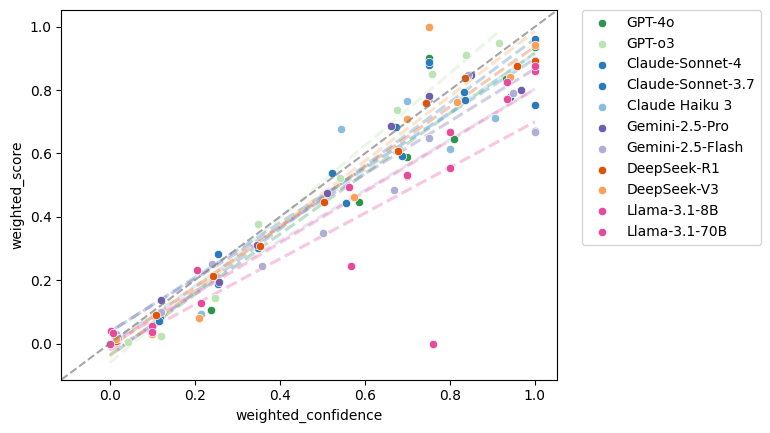

In [ ]:
merged_test = weight_avg_df(inverted['Claude Haiku 3'])
display(merged_test)

full_merge = pd.DataFrame(
    'bins':
)

for model_name, model_dict in inverted.items():
    merged = weight_avg_df(model_dict=model_dict)
    full_merge = pd.merge
    sns.regplot(
        data=merged,
        x='mean_confidence',
        y='mean_score',
        ci=None,
        scatter=False,
        color=pick_color(model_name),
        line_kws={'linestyle': '--', 'alpha': 0.3, "zorder": 1},

    )

        
    sns.scatterplot(
        merged, 
        x= 'mean_confidence', 
        y= 'mean_score', 
        color = pick_color(model_name), 
        label = model_name, 
        alpha = 1,
        zorder = 2
        )
    
lims = [
    min(plt.xlim()[0], plt.ylim()[0]),
    max(plt.xlim()[1], plt.ylim()[1])
]
plt.plot(lims, lims, '--', color='grey', alpha=0.7)
plt.xlim(lims)
plt.ylim(lims)

plt.legend(
    bbox_to_anchor=(1.05, 1),   # shift legend outside
    loc='upper left',           # anchor point
    borderaxespad=0.
)
plt.show()


In [205]:
full_merge = {}

for model_name, model_dict in inverted.items():
    full_merge[model_name] = weight_avg_df(model_dict=model_dict)

full_merge_df = weight_avg_df(full_merge)
full_merge_df

,bin,mean_confidence,mean_score,count
0,0.1,0.016409,0.018035,40447
1,0.2,0.107244,0.051367,6274
2,0.3,0.230437,0.145724,2549
3,0.4,0.349845,0.325410,335
4,0.5,0.551494,0.471838,2940
5,0.6,0.691365,0.631696,4032
6,0.7,0.754031,0.835128,988
7,0.8,0.819786,0.740354,8979
8,0.9,0.939052,0.819756,31643
9,1.0,1.000000,0.778870,13630


In [213]:
sum(full_merge_df['count'])

111817

<Axes: xlabel='mean_confidence', ylabel='mean_score'>

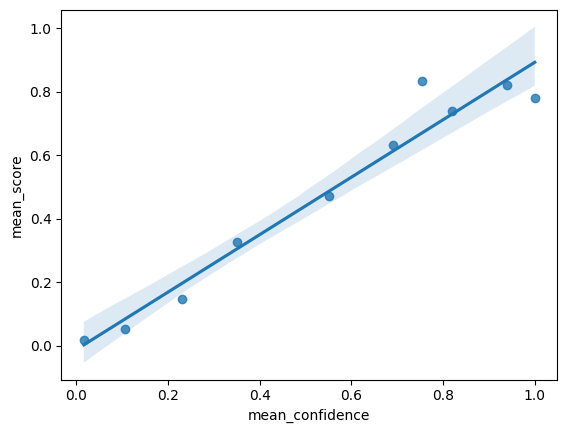

In [206]:
sns.regplot(full_merge_df, x = 'mean_confidence', y= 'mean_score', scatter = True)

### Only MCQ

In [208]:
melted_dict.keys()

dict_keys(['BoolQ', 'HaluEval', 'LifeEval', 'LSAT-AR', 'SAT-EN', 'SciQ'])

In [215]:
mcq_merge = {}
# Combined Calibration plot
mcq_inverted = {}
for outer_key, inner_dict in melted_dict.items():
    if outer_key not in mcq_qsets:
        continue
    for inner_key, value in inner_dict.items():
        if inner_key not in mcq_inverted:
            mcq_inverted[inner_key] = {}
        mcq_inverted[inner_key][outer_key] = value



for model_name, model_dict in mcq_inverted.items():
    full_merge[model_name] = weight_avg_df(model_dict=model_dict)

mcq_merge_df = weight_avg_df(full_merge)
mcq_merge_df

,bin,mean_confidence,mean_score,count
0,0.1,0.016758,0.014206,35689
1,0.2,0.104592,0.042068,5396
2,0.3,0.215046,0.136018,1316
3,0.4,0.350714,0.357143,14
4,0.5,0.545407,0.638554,664
5,0.6,0.695485,0.870680,897
6,0.7,0.751186,0.952569,253
7,0.8,0.822789,0.920906,2693
8,0.9,0.937430,0.971414,5912
9,1.0,1.000000,0.932587,3486


In [239]:

np.mean(full_merge_df['mean_score'] ), np.mean(mcq_merge_df['mean_score'])

(0.48181788440178835, 0.5836146400830093)

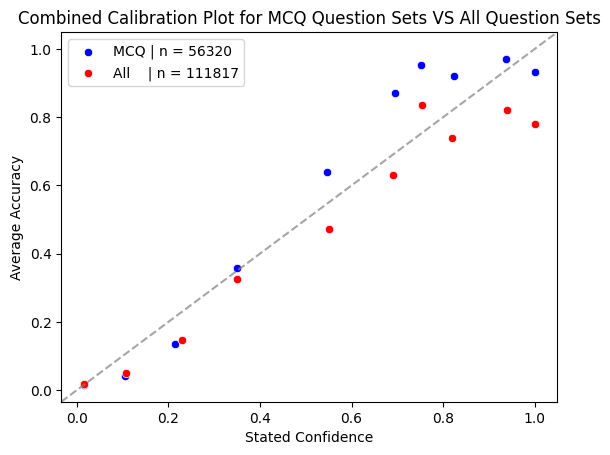

In [ ]:
sns.scatterplot(mcq_merge_df,  x= 'mean_confidence', y = 'mean_score', color = 'b', label =f'MCQ | n = {sum(mcq_merge_df['count'])}', legend= 'auto')
sns.scatterplot(full_merge_df, x= 'mean_confidence', y= 'mean_score',  color = 'r', label = f'All    | n = {sum(full_merge_df['count'])}', legend= 'auto')
 
lims = [
    min(plt.xlim()[0], plt.ylim()[0]),
    max(plt.xlim()[1], plt.ylim()[1])
]
plt.plot(lims, lims, '--', color='grey', alpha=0.7)
plt.xlim(lims)
plt.ylim(lims)

plt.title('Combined Calibration Plot for MCQ Question Sets VS All Question Sets')
plt.xlabel('Stated Confidence')
plt.ylabel('Average Accuracy')
plt.show()



## Summary Table

In [40]:
import pandas as pd

metrics = ["accuracy", "n", "ece", "over_confidence", "mean_gini"]
rows = []

for dataset, dataset_dict in summary_stats.items():
    for metric in metrics:
        row = {"Dataset": dataset, "Metric": metric}
        
        if metric not in dataset_dict:
            continue
        
        for entry in dataset_dict[metric]:
            # unpack tuple
            model_name = entry[0]
            metric_value = entry[1]
            # the rest of entry (entry[2:]) is extra info you may ignore
            row[model_name] = metric_value
        
        rows.append(row)

# Build DataFrame
table_df = pd.DataFrame(rows)

# Set multi-index for nice formatting
table_df = table_df.set_index(["Dataset", "Metric"])

display(table_df)


GPT-4o       GPT-o3  Claude-Sonnet-4  \
Dataset  Metric                                                       
BoolQ    accuracy           85.314126    86.074430        84.353741   
         n                3268.000000  3268.000000      3268.000000   
         ece                 0.079728     0.044166         0.079608   
         over_confidence     0.079408    -0.034786         0.076246   
HaluEval accuracy           52.147239    52.147239        52.147239   
         n                2000.000000  1991.000000      2000.000000   
         ece                 0.244702     0.022175         0.448132   
         over_confidence     0.243586     0.017078         0.435304   
LifeEval accuracy           54.549136    54.247985        53.977573   
         n                 808.000000   761.000000       808.000000   
         ece                 0.402330     0.458660         0.502091   
         over_confidence     0.052178    -0.001140        -0.041866   
LSAT-AR  accuracy           35.227273    96.590909        44.318182   
         n                 230.000000   193.000000       188.000000   
         ece                 0.505114     0.150455         0.321023   
         over_confidence     0.507955    -0.150455         0.290530   
         mean_gini           0.674864     0.635136         0.590048   
SAT-EN   accuracy           93.103448    97.701149        98.275862   
         n                 206.000000   205.000000       206.000000   
         ece                 0.150862     0.221839         0.165517   
         over_confidence    -0.139368    -0.221839        -0.161207   
         mean_gini           0.554009     0.545029         0.596250   
SciQ     accuracy           96.887550    98.092369        96.887550   
         n                1000.000000  1000.000000      1000.000000   
         ece                 0.054317     0.154709         0.054618   
         over_confidence    -0.050000    -0.154709        -0.052510   
         mean_gini           0.680263     0.607304         0.683758   

                          Claude-Sonnet-3.7  Claude Haiku 3  Gemini-2.5-Pro  \
Dataset  Metric                                                               
BoolQ    accuracy                 83.193277       78.151261       53.621449   
         n                      3267.000000     3242.000000     3192.000000   
         ece                       0.123849        0.117315        0.457815   
         over_confidence           0.123849        0.116194        0.457295   
HaluEval accuracy                 52.147239       52.147239       52.147239   
         n                      2000.000000     1855.000000     1984.000000   
         ece                       0.080084        0.365616        0.105326   
         over_confidence           0.077853        0.365059        0.080006   
LifeEval accuracy                 54.494200       53.023114       53.840331   
         n                       808.000000      808.000000      808.000000   
         ece                       0.468895        0.202397        0.465807   
         over_confidence          -0.013837        0.267372       -0.004210   
LSAT-AR  accuracy                 42.045455       26.136364       96.590909   
         n                       229.000000      230.000000      188.000000   
         ece                       0.390909        0.442045        0.014205   
         over_confidence           0.390909        0.434659        0.014205   
         mean_gini                 0.670318        0.570868        0.781580   
SAT-EN   accuracy                 97.126437       84.482759       98.850575   
         n                       206.000000      181.000000      204.000000   
         ece                       0.135977        0.188506        0.068333   
         over_confidence          -0.134540       -0.170977       -0.060862   
         mean_gini                 0.611365        0.482062        0.690158   
SciQ     accuracy                 97.289157       94.076305       97.590361

In [33]:
dataset_dict[metric]

0.7105923694779116

In [41]:
# --- clean up metric names ---
table_df = table_df.rename(index={
    "n": "Completions",
    "accuracy": "Accuracy",
    "ece": "ECE",
    "over_confidence": "Overconfidence",
    "mean_gini": "Average Gini"
})

# --- round everything else to 3 decimals ---
table_df = table_df.round(3)

# --- force Completions to integers ---
table_df.loc[(slice(None), "Completions"), :] = (
    table_df.loc[(slice(None), "Completions"), :].astype(float).astype(int)
)

table_df


GPT-4o    GPT-o3  Claude-Sonnet-4  \
Dataset  Metric                                                
BoolQ    Accuracy          85.314    86.074           84.354   
         Completions     3268.000  3268.000         3268.000   
         ECE                0.080     0.044            0.080   
         Overconfidence     0.079    -0.035            0.076   
HaluEval Accuracy          52.147    52.147           52.147   
         Completions     2000.000  1991.000         2000.000   
         ECE                0.245     0.022            0.448   
         Overconfidence     0.244     0.017            0.435   
LifeEval Accuracy          54.549    54.248           53.978   
         Completions      808.000   761.000          808.000   
         ECE                0.402     0.459            0.502   
         Overconfidence     0.052    -0.001           -0.042   
LSAT-AR  Accuracy          35.227    96.591           44.318   
         Completions      230.000   193.000          188.000   
         ECE                0.505     0.150            0.321   
         Overconfidence     0.508    -0.150            0.291   
         Average Gini       0.675     0.635            0.590   
SAT-EN   Accuracy          93.103    97.701           98.276   
         Completions      206.000   205.000          206.000   
         ECE                0.151     0.222            0.166   
         Overconfidence    -0.139    -0.222           -0.161   
         Average Gini       0.554     0.545            0.596   
SciQ     Accuracy          96.888    98.092           96.888   
         Completions     1000.000  1000.000         1000.000   
         ECE                0.054     0.155            0.055   
         Overconfidence    -0.050    -0.155           -0.053   
         Average Gini       0.680     0.607            0.684   

                         Claude-Sonnet-3.7  Claude Haiku 3  Gemini-2.5-Pro  \
Dataset  Metric                                                              
BoolQ    Accuracy                   83.193          78.151          53.621   
         Completions              3267.000        3242.000        3192.000   
         ECE                         0.124           0.117           0.458   
         Overconfidence              0.124           0.116           0.457   
HaluEval Accuracy                   52.147          52.147          52.147   
         Completions              2000.000        1855.000        1984.000   
         ECE                         0.080           0.366           0.105   
         Overconfidence              0.078           0.365           0.080   
LifeEval Accuracy                   54.494          53.023          53.840   
         Completions               808.000         808.000         808.000   
         ECE                         0.469           0.202           0.466   
         Overconfidence             -0.014           0.267          -0.004   
LSAT-AR  Accuracy                   42.045          26.136          96.591   
         Completions               229.000         230.000         188.000   
         ECE                         0.391           0.442           0.014   
         Overconfidence              0.391           0.435           0.014   
         Average Gini                0.670           0.571           0.782   
SAT-EN   Accuracy                   97.126          84.483          98.851   
         Completions               206.000         181.000         204.000   
         ECE                         0.136           0.189           0.068   
         Overconfidence             -0.135          -0.171          -0.061   
         Average Gini                0.611           0.482           0.690   
SciQ     Accuracy                   97.289          94.076          97.590   
         Completions              1000.000         999.000        1000.000   
         ECE                         0.050           0.110           0.031   
         Overconfidence             -0.049          -0.096      

In [48]:
#--- To Latex

latex_code = table_df.to_latex(
    multicolumn=True,
    multirow=True,
    float_format="%.3f",
    column_format="ll" + "c" * len(table_df.columns)  # align Dataset, Metric, then models
)

# Wrap in table* manually
latex_code = latex_code.replace("\\begin{tabular}", "\\begin{table*}[t]\n\\centering\n\\scriptsize\n\\begin{tabular}")
latex_code = latex_code.replace("\\end{tabular}", "\\end{tabular}\n\\caption{Performance across datasets and models.}\n\\label{tab:results}\n\\end{table*}")

print(latex_code)

\begin{table*}[t]
\centering
\scriptsize
\begin{tabular}{llccccccccccc}
\toprule
 &  & GPT-4o & GPT-o3 & Claude-Sonnet-4 & Claude-Sonnet-3.7 & Claude Haiku 3 & Gemini-2.5-Pro & Gemini-2.5-Flash & DeepSeek-R1 & DeepSeek-V3 & Llama-3.1-8B & Llama-3.1-70B \\
Dataset & Metric &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{BoolQ} & Accuracy & 85.314 & 86.074 & 84.354 & 83.193 & 78.151 & 53.621 & 52.101 & 84.514 & 82.913 & 69.348 & 78.591 \\
 & Completions & 3268.000 & 3268.000 & 3268.000 & 3267.000 & 3242.000 & 3192.000 & 3265.000 & 3260.000 & 3270.000 & 3241.000 & 3257.000 \\
 & ECE & 0.080 & 0.044 & 0.080 & 0.124 & 0.117 & 0.458 & 0.472 & 0.111 & 0.102 & 0.170 & 0.124 \\
 & Overconfidence & 0.079 & -0.035 & 0.076 & 0.124 & 0.116 & 0.457 & 0.472 & 0.111 & 0.100 & 0.166 & 0.120 \\
\cline{1-13}
\multirow[t]{4}{*}{HaluEval} & Accuracy & 52.147 & 52.147 & 52.147 & 52.147 & 52.147 & 52.147 & 52.147 & 52.147 & 52.147 & 52.171 & 52.147 \\
 & Completions & 2000.000 & 1991.000 & 20

In [62]:
table_df

GPT-4o    GPT-o3  Claude-Sonnet-4  \
Dataset  Metric                                                
BoolQ    Accuracy          85.314    86.074           84.354   
         Completions     3268.000  3268.000         3268.000   
         ECE                0.080     0.044            0.080   
         Overconfidence     0.079    -0.035            0.076   
HaluEval Accuracy          52.147    52.147           52.147   
         Completions     2000.000  1991.000         2000.000   
         ECE                0.245     0.022            0.448   
         Overconfidence     0.244     0.017            0.435   
LifeEval Accuracy          54.549    54.248           53.978   
         Completions      808.000   761.000          808.000   
         ECE                0.402     0.459            0.502   
         Overconfidence     0.052    -0.001           -0.042   
LSAT-AR  Accuracy          35.227    96.591           44.318   
         Completions      230.000   193.000          188.000   
         ECE                0.505     0.150            0.321   
         Overconfidence     0.508    -0.150            0.291   
         Average Gini       0.675     0.635            0.590   
SAT-EN   Accuracy          93.103    97.701           98.276   
         Completions      206.000   205.000          206.000   
         ECE                0.151     0.222            0.166   
         Overconfidence    -0.139    -0.222           -0.161   
         Average Gini       0.554     0.545            0.596   
SciQ     Accuracy          96.888    98.092           96.888   
         Completions     1000.000  1000.000         1000.000   
         ECE                0.054     0.155            0.055   
         Overconfidence    -0.050    -0.155           -0.053   
         Average Gini       0.680     0.607            0.684   

                         Claude-Sonnet-3.7  Claude Haiku 3  Gemini-2.5-Pro  \
Dataset  Metric                                                              
BoolQ    Accuracy                   83.193          78.151          53.621   
         Completions              3267.000        3242.000        3192.000   
         ECE                         0.124           0.117           0.458   
         Overconfidence              0.124           0.116           0.457   
HaluEval Accuracy                   52.147          52.147          52.147   
         Completions              2000.000        1855.000        1984.000   
         ECE                         0.080           0.366           0.105   
         Overconfidence              0.078           0.365           0.080   
LifeEval Accuracy                   54.494          53.023          53.840   
         Completions               808.000         808.000         808.000   
         ECE                         0.469           0.202           0.466   
         Overconfidence             -0.014           0.267          -0.004   
LSAT-AR  Accuracy                   42.045          26.136          96.591   
         Completions               229.000         230.000         188.000   
         ECE                         0.391           0.442           0.014   
         Overconfidence              0.391           0.435           0.014   
         Average Gini                0.670           0.571           0.782   
SAT-EN   Accuracy                   97.126          84.483          98.851   
         Completions               206.000         181.000         204.000   
         ECE                         0.136           0.189           0.068   
         Overconfidence             -0.135          -0.171          -0.061   
         Average Gini                0.611           0.482           0.690   
SciQ     Accuracy                   97.289          94.076          97.590   
         Completions              1000.000         999.000        1000.000   
         ECE                         0.050           0.110           0.031   
         Overconfidence             -0.049          -0.096      

[('GPT-4o',
  0.6802634415211868,
  'GPT',
  (0.17139561707035755, 0.581514801999231, 0.2979008073817762)),
 ('GPT-o3',
  0.6073042168674698,
  'GPT',
  (0.7371472510572856, 0.895517108804306, 0.7108342945021145)),
 ('Claude-Sonnet-4',
  0.683757530120482,
  'Claude',
  (0.16696655132641292, 0.48069204152249134, 0.7291503267973857)),
 ('Claude-Sonnet-3.7',
  0.6936366834170854,
  'Claude',
  (0.16696655132641292, 0.48069204152249134, 0.7291503267973857)),
 ('Claude Haiku 3',
  0.6272400967506389,
  'Claude',
  (0.5356862745098039, 0.746082276047674, 0.8642522106881968)),
 ('Gemini-2.5-Pro',
  0.7151506024096386,
  'Gemini',
  (0.440722798923491, 0.36772010765090346, 0.6653902345251825)),
 ('Gemini-2.5-Flash',
  0.6949560742971888,
  'Gemini',
  (0.6878892733564014, 0.6835832372164552, 0.829834678969627)),
 ('DeepSeek-R1',
  0.7577667108433734,
  'DeepSeek',
  (0.8782929642445213, 0.31990772779700116, 0.024405997693194924)),
 ('DeepSeek-V3',
  0.7088104417670682,
  'DeepSeek',
  (0.9921

### LifeEval:

In [41]:
#-- Helper functions:

def compute_prob(point_estimate: float,
                 R: float,
                 gender: str,          # 'male' or 'female' (case-insensitive)
                 min_age: int,         # condition "already lived at least min_age"
                 df: pd.DataFrame) -> float:
    """
    Using a life table with columns:
      - 'Age'
      - 'Death probability (MALE)'
      - 'Death probability (FEMALE)'
    compute P(death occurs within [point_estimate - R, point_estimate + R] | survived to min_age).
    """

    if "Age" not in df.columns:
        raise ValueError("Expected an 'Age' column in the life table.")

    g = gender.strip().lower()
    if g not in ("male", "female"):
        raise ValueError("gender must be 'male' or 'female'")

    qx_col_map = {
        "male":   "Death probability (MALE)",
        "female": "Death probability (FEMALE)",
    }
    qx_col = qx_col_map[g]
    if qx_col not in df.columns:
        raise ValueError(f"Expected column '{qx_col}' in the life table.")

    # Work on a clean copy sorted by Age
    tab = df[["Age", qx_col]].copy().sort_values("Age").reset_index(drop=True)
    tab.rename(columns={qx_col: "q"}, inplace=True)
    tab["Age"] = tab["Age"].astype(int)
    tab["q"] = tab["q"].astype(float)

    # Integer-age window [lo, hi), clamped to table bounds and min_age
    table_min = int(tab["Age"].min())
    table_max = int(tab["Age"].max())  # last age with q_x for [x, x+1)
    lo = max(int(np.floor(point_estimate - R)), int(min_age), table_min)
    hi = min(int(np.ceil(point_estimate + R)), table_max + 1)  # exclusive upper bound

    if hi <= lo:
        return 0.0

    # Align to contiguous ages and extract q_x as numpy
    ages = np.arange(table_min, table_max + 1, dtype=int)
    sub = tab.set_index("Age").reindex(ages)
    if sub["q"].isna().any():
        # restrict to contiguous valid block if necessary
        valid = sub["q"].notna()
        first = int(ages[valid.argmax()])
        last = int(ages[::-1][valid.iloc[::-1].argmax()])
        lo = max(lo, first)
        hi = min(hi, last + 1)
        if hi <= lo:
            return 0.0
        sub = sub.loc[first:last]
        ages = sub.index.values

    q = sub["q"].to_numpy()
    offset = int(ages[0])

    # Survival from min_age (m)
    m = max(int(min_age), int(ages[0]))
    if m >= hi:
        return 0.0

    one_minus_q = 1.0 - q
    start = m - offset
    end_excl = hi - offset

    # Relative survival S_rel(x) = Π_{k=m}^{x-1} (1-q_k), with S_rel(m)=1
    S_rel = np.ones(end_excl - start + 1, dtype=float)
    if end_excl - start > 0:
        S_rel[1:] = np.cumprod(one_minus_q[start:end_excl])

    # Sum P(T in [x, x+1) | T >= m) = S_rel(x) * q_x for x = max(lo,m) .. hi-1
    x0 = max(lo, m)
    xs = np.arange(x0, hi, dtype=int)
    if xs.size == 0:
        return 0.0

    idx = xs - offset
    S_rel_x = S_rel[(xs - m)]
    q_x = q[idx]
    prob = float(np.sum(S_rel_x * q_x))

    # Clamp for numerical safety
    return max(0.0, min(1.0, prob))
#example_prob = compute_prob(76, 1, 'male', 17, act)
#example_prob

In [ ]:
# Compare overconfidence by radius

stats = summary_stats['LifeEval']

ece_df = pd.DataFrame(stats['ece'], columns=["model", "ece", "family", "color"])
oc_df  = pd.DataFrame(stats['over_confidence'],  columns=["model", "over_confidence", "family", "color"])
acc_df = pd.DataFrame(stats['accuracy'], columns=["model", "acc", "family", "color"])
n_df   = pd.DataFrame(stats['n'],   columns=["model", "n",   "family", "color"])

combined = (
    ece_df
    .merge(oc_df, on=["model", "family", "color"], how="outer")
    .merge(acc_df, on=["model", "family", "color"], how="outer")
    .merge(n_df, on=["model", "family", "color"], how="outer")
)




In [60]:
def score_life_eval(df, act_table):
    answers = df['Answer']
    confidence = df['Confidence']
    qid = df['Question ID']

    # Get Radius
    radius_list = [1, 5, 10, 20]
    # Get the modulus of QID then use that as an index for radius_list such that 0-> 1, 1-> 5, 2-> 10, 3-> 20
    mod_qid = df['Question ID'].astype('int').apply(lambda x: x % 4)


    rads = mod_qid.apply(lambda i: radius_list[i])
    #df['radius'] = rads

    #Gold Answer:

    all_data = pd.DataFrame({
        'Question ID': qid,
        'Answer': answers,
        'Confidence': confidence.astype(float),
        'Radius': rads,
        #'Gold': gold
    })

    data = all_data[all_data['Answer'].notna()].copy()
    data['Gender'] = ['female' if i >= 404 else 'male' for i in df.index]
    data['Age'] = [get_age(qid) for qid in df['Question ID']]



    data['Probability'] = data.apply(lambda row: compute_prob(
        point_estimate= row['Answer'],
        min_age= row['Age'],
        gender= row['Gender'],
        R= row['Radius'],
        df = act_table
        ),
        axis = 1
        )

    data['Overconfidence'] = (data['Confidence'] - data['Probability'])
    return data

<>:9: SyntaxWarning: invalid escape sequence '\P'
<>:9: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_73016\3144263765.py:9: SyntaxWarning: invalid escape sequence '\P'
  act_table = pd.read_csv('Formatted Benchmarks\PeriodLifeTable_2022_RawData.csv')


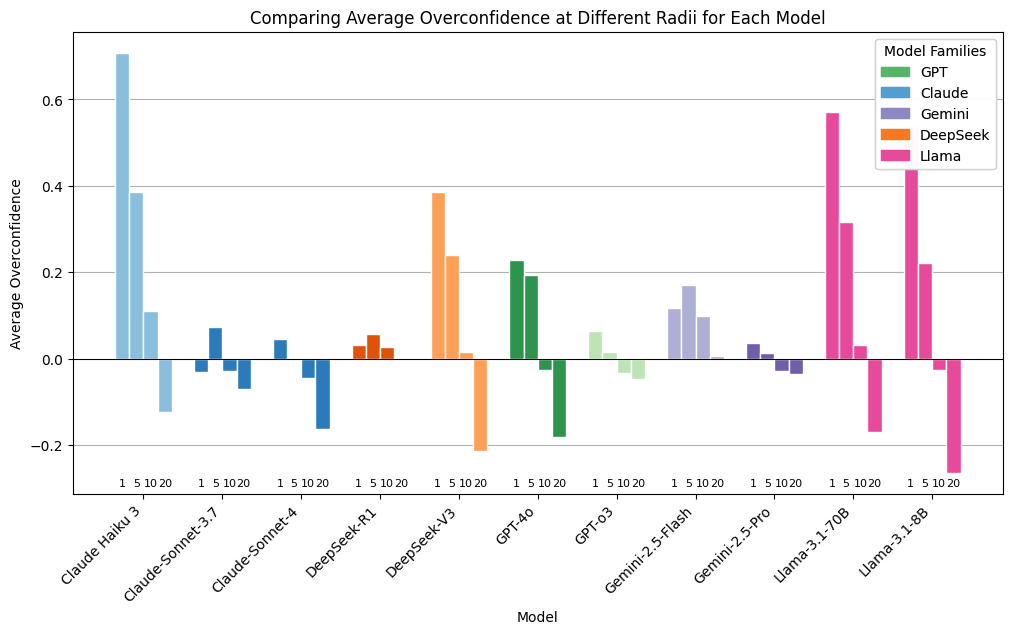

In [ ]:
def plot_overconfidence_life_eval():


    qset_name = 'LifeEval'
    gold_df_path = 'Formatted Benchmarks\\life_eval_formatted.csv'
    gold_df = pd.read_csv(gold_df_path)
    gold = gold_df['True Lifespan']

    act_table = pd.read_csv('Formatted Benchmarks\\PeriodLifeTable_2022_RawData.csv')

    combined_data = pd.DataFrame()
    combined = pd.DataFrame()

    for model_name, df in dfs[qset_name].items():

        # Get Radius
        radius_list = [1, 5, 10, 20]
        # Get the modulus of QID then use that as an index for radius_list such that 0-> 1, 1-> 5, 2-> 10, 3-> 20
        mod_qid = df['Question ID'].astype('int').apply(lambda x: x % 4)


        rads = mod_qid.apply(lambda i: radius_list[i])
        data = df.copy()
        data['Radius'] = rads
        data = score_life_eval(data, act_table.dropna() )

        data["Overconfidence"] = data["Confidence"] - data["Score"]

        agg_df = data.groupby("Radius")["Overconfidence"].mean().reset_index()
        agg_df['Model'] = model_name#.all()
        agg_df['Fam'] = model_family(model_name)

        combined_data = pd.concat([combined_data, data])
        combined = pd.concat([combined, agg_df])



    combined_data

    # Ensure Radius ordering
    radius_order = [1.0, 5.0, 10.0, 20.0]

    # Pivot table (rows = Model, cols = Radius)
    pivot = (
        combined.pivot_table(index="Model", columns="Radius", values="Overconfidence", aggfunc="mean")
        .reindex(columns=radius_order).sort_values("Model")
    )

    fig, ax = plt.subplots(figsize=(12, 6))

    n_models = len(pivot.index)
    n_groups = len(pivot.columns)
    x = np.arange(n_models)
    bar_w = 0.18

    # Draw bars
    for i, r in enumerate(pivot.columns):
        colors = [pick_color(m) for m in pivot.index]
        bars = ax.bar(
            x + (i - (n_groups-1)/2)*bar_w,
            pivot[r].values,
            width=bar_w,
            color=colors,
            zorder=3,
            label=f"Radius {int(r)}" if i == 0 else "" , # legend for radius only once
            edgecolor = 'white'
        )
        # Add radius label at bottom above x-axis
        for bar in bars:
            bar_x = bar.get_x() + bar.get_width() / 2
            ax.text(bar_x, -0.3,
                    f"{int(r)}",
                    ha="center", va="bottom", fontsize=8)

    ax.set_ylabel("Average Overconfidence")
    ax.set_xlabel('Model')
    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index, rotation=45, ha="right")

    # Legends
    # 1. Radius legend (already handled by bar label)
    #ax.legend(title="Radius", loc="upper right", bbox_to_anchor = (1.05, 1.05))

    # 2. Family color legend
    families = ["GPT", "Claude", "Gemini", "DeepSeek", "Llama"]
    family_patches = [Patch(color=family_palettes[fam][3], label=fam) for fam in families]
    ax.add_artist(ax.legend(handles=family_patches, title="Model Families", loc="upper right", ))

    ax.axhline(0, color="black", linestyle="-", linewidth=0.75, zorder = 4) # y = 0 line for context

    ax.set_axisbelow(True)
    ax.grid(axis="y", zorder=0)
    ax.set_title('Comparing Average Overconfidence at Different Radii for Each Model')
    plt.show()

plot_overconfidence_life_eval()

In [45]:
dfs['LifeEval']['GPT-4o']#['Overconfidence']

,Unnamed: 0,Reasoning,Answer,Confidence,coerce,content,Question ID,radius,Expected Age
0,0,The life expectancy for an American male at bi...,76,0.1,True,"{\n ""Reasoning"": ""The life expectancy for a...",0,1,74.74
1,1,The life expectancy for an American male at bi...,76,0.6,True,"{\n ""Reasoning"": ""The life expectancy for a...",1,5,74.74
2,2,The life expectancy for an American male at bi...,76,0.6,True,"{\n ""Reasoning"": ""The life expectancy for a...",2,10,74.74
3,3,The life expectancy for an American male is ap...,76,0.7,True,"{\n ""Reasoning"": ""The life expectancy for a...",3,20,74.74
4,4,The life expectancy for an American male at bi...,77,0.6,True,"{\n ""Reasoning"": ""The life expectancy for a...",4,1,75.20
...,...,...,...,...,...,...,...,...,...
803,803,The life expectancy for an American female is ...,105,0.7,True,"{\n ""Reasoning"": ""The life expectancy for a...",803,20,NaN
804,804,The life expectancy for an American female is ...,105,0.3,True,"{\n ""Reasoning"": ""The life expectancy for a...",804,1,NaN
805,805,The life expectancy for an American female who...,107,0.6,True,"{\n ""Reasoning"": ""The life expectancy for a...",805,5,NaN
806,806,The life expectancy for an American female is ...,107,0.6,True,"{\n ""Reasoning"": ""The life expectancy for a...",806,10,NaN


In [771]:
qset_name = 'LifeEval'
gold_df_path = 'Formatted Benchmarks\\life_eval_formatted.csv'
gold_df = pd.read_csv(gold_df_path)
gold = gold_df['True Lifespan']

combined_data = pd.DataFrame()
combined = pd.DataFrame()

for model_name, df in dfs[qset_name].items():
    answers = df['Answer']
    confidence = df['Confidence']
    qid = df['Question ID']

    # Get Radius
    radius_list = [1, 5, 10, 20]
    # Get the modulus of QID then use that as an index for radius_list such that 0-> 1, 1-> 5, 2-> 10, 3-> 20
    mod_qid = df['Question ID'].astype('int').apply(lambda x: x % 4)


    rads = mod_qid.apply(lambda i: radius_list[i])
    #df['radius'] = rads

    #Gold Answer:

    all_data = pd.DataFrame({
        'Question ID': qid,
        'Answer': answers,
        'Confidence': confidence.astype(float),
        'Radius': rads,
        'Gold': gold
    })

    data = all_data[all_data['Answer'].notna()].copy()
    data['Gender'] = ['female' if i >= 404 else 'male' for i in df.index]
    data['Age'] = [get_age(qid) for qid in df['Question ID']]

    data['Score'] = (
                    (data['Answer'].astype(float) >= data['Gold'] - data['Radius']) &
                    (data['Answer'].astype(float) <= data['Gold'] + data['Radius'])
                ).astype(int)

    data['Probability'] = data.apply(lambda row: compute_prob(
        point_estimate= row['Answer'],
        min_age= row['Age'],
        gender= row['Gender'],
        R= row['Radius'],
        df = act
        ),
        axis = 1
        )

    data['Overconfidence'] = (data['Confidence'] - data['Probability'])
    agg_df = data.groupby("Radius")["Overconfidence"].mean().reset_index()
    agg_df['Model'] = model_name#.all()
    agg_df['Fam'] = model_family(model_name)

    combined_data = pd.concat([combined_data, data])
    combined = pd.concat([combined, agg_df])

combined_data

,Question ID,Answer,Confidence,Radius,Gold,Gender,Age,Score,Probability,Overconfidence
0,0.0,76.0,0.1,1.0,74.74,male,0,0,0.046215,0.053785
1,1.0,76.0,0.6,5.0,74.74,male,0,1,0.232835,0.367165
2,2.0,76.0,0.6,10.0,74.74,male,0,1,0.469277,0.130723
3,3.0,76.0,0.7,20.0,74.74,male,0,1,0.831361,-0.131361
4,4.0,77.0,0.6,1.0,75.20,male,1,0,0.049337,0.550663
...,...,...,...,...,...,...,...,...,...,...
803,803.0,105.0,0.8,20.0,101.30,female,99,1,1.000000,-0.200000
804,804.0,102.0,0.8,1.0,102.14,female,100,1,0.403651,0.396349
805,805.0,105.0,0.8,5.0,102.14,female,100,1,0.998065,-0.198065
806,806.0,105.0,0.7,10.0,102.14,female,100,1,0.999996,-0.299996


In [770]:
# --- Just analysis on Claude - Sonnet -4 
act = pd.read_csv('Formatted Benchmarks\\PeriodLifeTable_2022_RawData.csv')
qset_name = 'LifeEval'
gold_df_path = 'Formatted Benchmarks\\life_eval_formatted.csv'
gold_df = pd.read_csv(gold_df_path)
gold = gold_df['True Lifespan']
model_name = 'Claude-Sonnet-4'


df  = dfs[qset_name][model_name]
print(f"USING {df.shape[0]} ROWS")
answers = df['Answer']
confidence = df['Confidence']
qid = df['Question ID']

# Get Radius
radius_list = [1, 5, 10, 20]
# Get the modulus of QID then use that as an index for radius_list such that 0-> 1, 1-> 5, 2-> 10, 3-> 20
mod_qid = df['Question ID'].astype('int').apply(lambda x: x % 4)


rads = mod_qid.apply(lambda i: radius_list[i])
#df['radius'] = rads

#Gold Answer:

all_data = pd.DataFrame({
    'Question ID': qid,
    'Answer': answers,
    'Confidence': confidence.astype(float),
    'Radius': rads,
    'Gold': gold
})

data = all_data[all_data['Answer'].notna()].copy()
data['Gender'] = ['female' if i >= 404 else 'male' for i in df.index]
data['Age'] = [get_age(qid) for qid in df['Question ID']]

data['Score'] = (
                (data['Answer'].astype(float) >= data['Gold'] - data['Radius']) &
                (data['Answer'].astype(float) <= data['Gold'] + data['Radius'])
            ).astype(int)

data['Probability'] = data.apply(lambda row: compute_prob(
    point_estimate= row['Answer'],
    min_age= row['Age'],
    gender= row['Gender'],
    R= row['Radius'],
    df = act
    ),
    axis = 1
    )

data['Overconfidence'] = (data['Confidence'] - data['Probability'])
agg_df = data.groupby("Radius")["Overconfidence"].mean().reset_index()
agg_df['Model'] = model_name#.all()



print(f"Data:")
display(data)

sd = data[data['Radius'] == 1.0]

print('Just R = 1')
print(f"Mean Probability: {np.mean(sd['Probability'])} Mean Confidence: {np.mean(sd['Confidence'])}")
print('Agregated:')
agg_df


#data[data['Answer'].isna()]

USING 751 ROWS
Data:


,Question ID,Answer,Confidence,Radius,Gold,Gender,Age,Score,Probability,Overconfidence
0,0.0,76.0,0.05,1.0,74.74,male,0,0,0.046215,0.003785
1,1.0,76.0,0.40,5.0,74.74,male,0,1,0.232835,0.167165
2,2.0,77.0,0.65,10.0,74.74,male,0,1,0.487341,0.162659
3,3.0,76.0,0.85,20.0,74.74,male,0,1,0.831361,0.018639
4,4.0,77.0,0.05,1.0,75.20,male,1,0,0.049337,0.000663
...,...,...,...,...,...,...,...,...,...,...
803,803.0,101.0,0.85,20.0,101.30,female,99,1,1.000000,-0.150000
804,804.0,102.0,0.15,1.0,102.14,female,100,1,0.403651,-0.253651
805,805.0,103.0,0.40,5.0,102.14,female,100,1,0.989382,-0.589382
806,806.0,103.0,0.60,10.0,102.14,female,100,1,0.999927,-0.399927


Just R = 1
Mean Probability: 0.10057361747607063 Mean Confidence: 0.14594594594594595
Agregated:


,Radius,Overconfidence,Model
0,1.0,0.045372,Claude-Sonnet-4
1,5.0,-0.001246,Claude-Sonnet-4
2,10.0,-0.045642,Claude-Sonnet-4
3,20.0,-0.163653,Claude-Sonnet-4


Text(0.5, 1.0, 'Average Confidence by Radius')

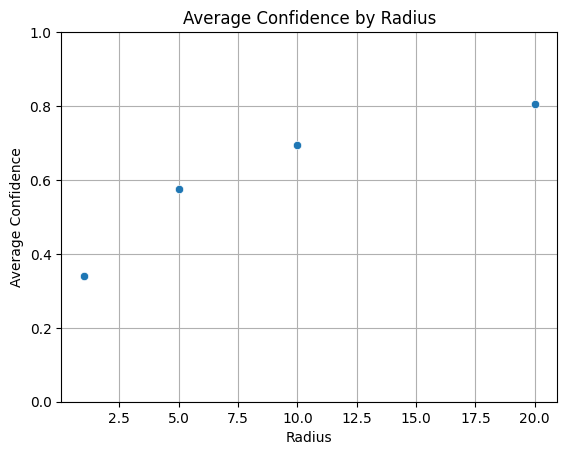

In [772]:

sns.scatterplot(scatter_group, zorder = 2)
#plt.errorbar(scatter_group.index, scatter_group, )
plt.ylabel('Average Confidence')
plt.grid(zorder = 0)

plt.ylim((0,1))
plt.title('Average Confidence by Radius')


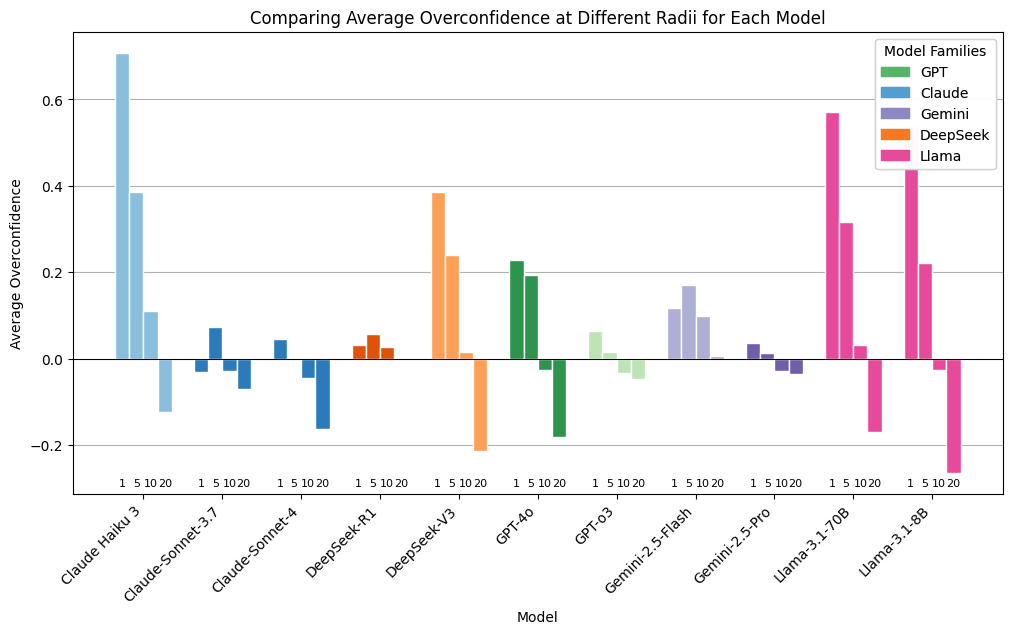

In [808]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Ensure Radius ordering
radius_order = [1.0, 5.0, 10.0, 20.0]

# Pivot table (rows = Model, cols = Radius)
pivot = (
    combined.pivot_table(index="Model", columns="Radius", values="Overconfidence", aggfunc="mean")
      .reindex(columns=radius_order).sort_values("Model")
)

fig, ax = plt.subplots(figsize=(12, 6))

n_models = len(pivot.index)
n_groups = len(pivot.columns)
x = np.arange(n_models)
bar_w = 0.18

# Draw bars
for i, r in enumerate(pivot.columns):
    colors = [pick_color(m) for m in pivot.index]
    bars = ax.bar(
        x + (i - (n_groups-1)/2)*bar_w,
        pivot[r].values,
        width=bar_w,
        color=colors,
        zorder=3,
        label=f"Radius {int(r)}" if i == 0 else "" , # legend for radius only once
        edgecolor = 'white'
    )
    # Add radius label at bottom above x-axis
    for bar in bars:
        bar_x = bar.get_x() + bar.get_width() / 2
        ax.text(bar_x, -0.3,
                f"{int(r)}",
                ha="center", va="bottom", fontsize=8)

ax.set_ylabel("Average Overconfidence")
ax.set_xlabel('Model')
ax.set_xticks(x)
ax.set_xticklabels(pivot.index, rotation=45, ha="right")

# Legends
# 1. Radius legend (already handled by bar label)
#ax.legend(title="Radius", loc="upper right", bbox_to_anchor = (1.05, 1.05))

# 2. Family color legend
families = ["GPT", "Claude", "Gemini", "DeepSeek", "Llama"]
family_patches = [Patch(color=family_palettes[fam][3], label=fam) for fam in families]
ax.add_artist(ax.legend(handles=family_patches, title="Model Families", loc="upper right", ))

ax.axhline(0, color="black", linestyle="-", linewidth=0.75, zorder = 4) # y = 0 line for context

ax.set_axisbelow(True)
ax.grid(axis="y", zorder=0)
ax.set_title('Comparing Average Overconfidence at Different Radii for Each Model')

#plt.tight_layout()
plt.subplots_adjust()
plt.show()


### Gini Plots

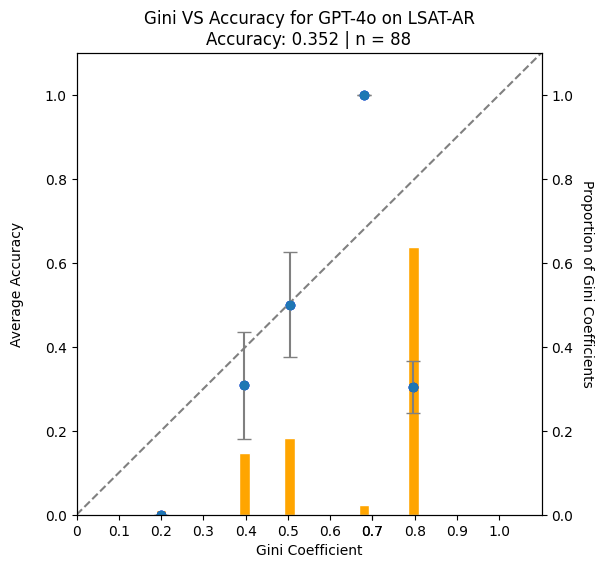

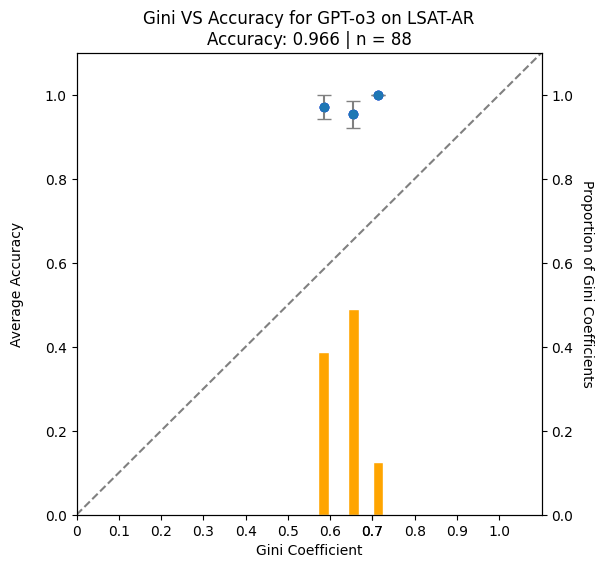

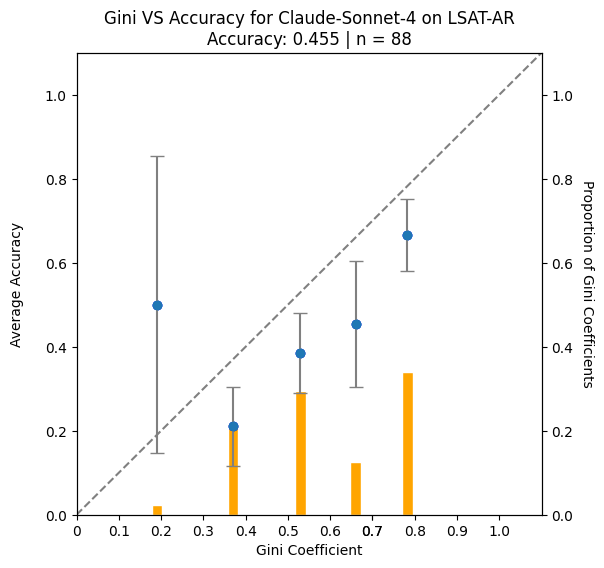

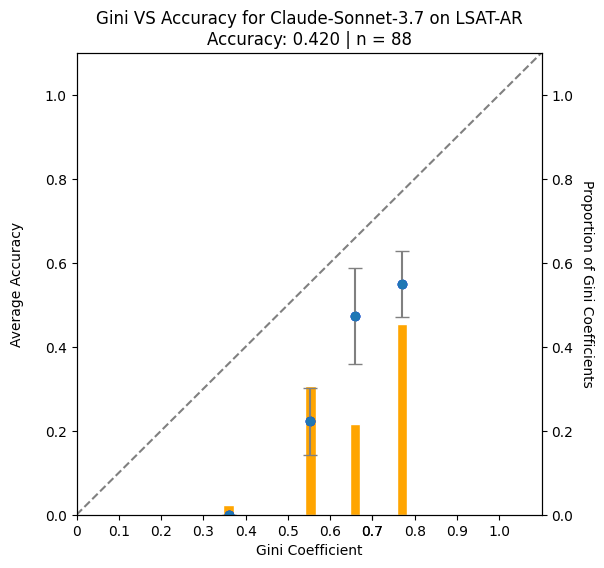

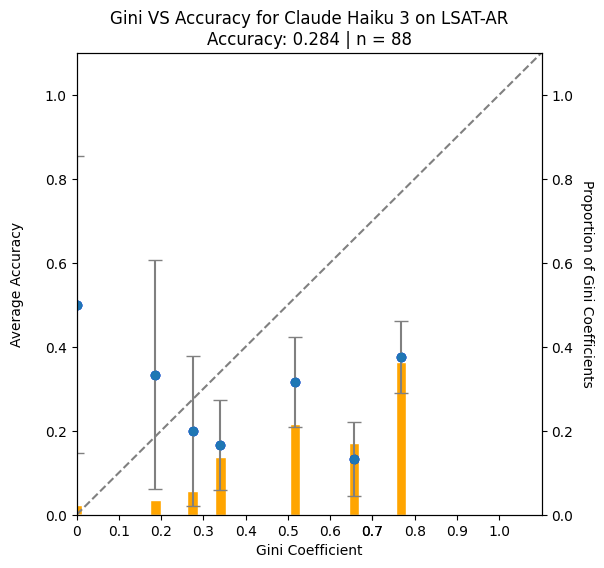

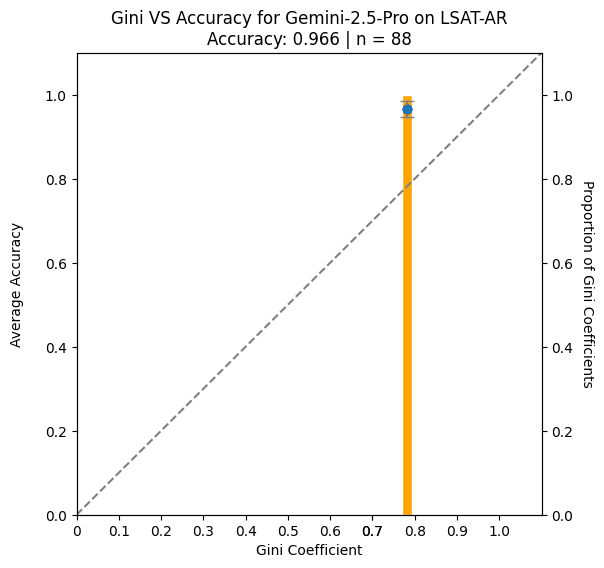

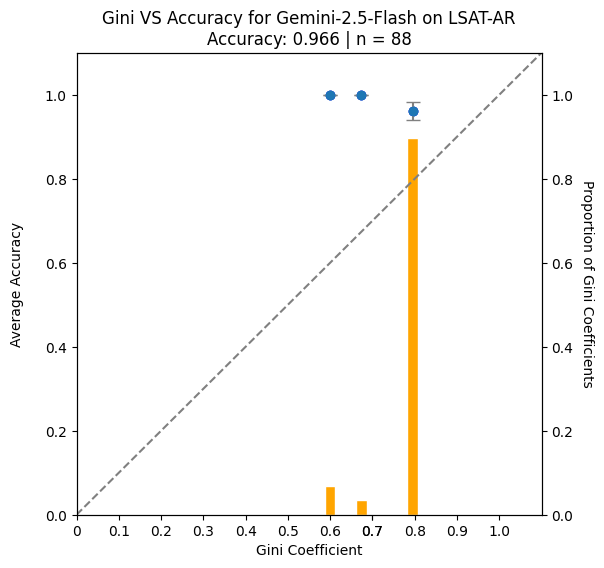

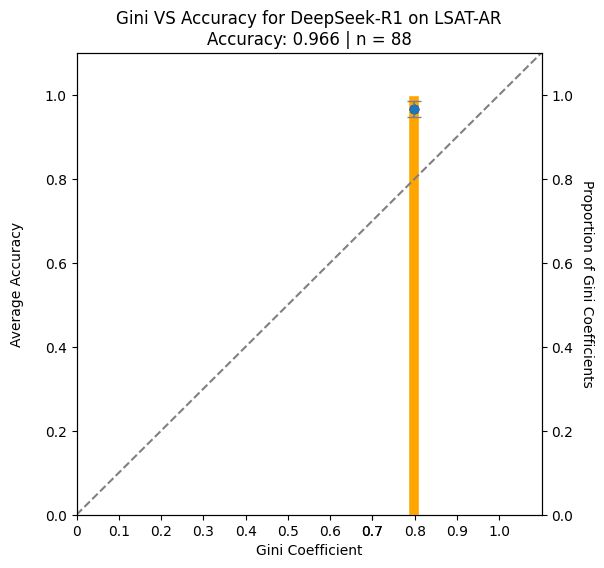

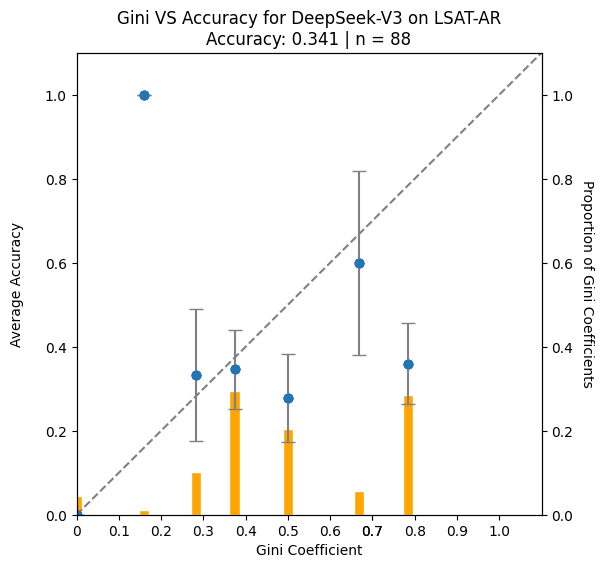

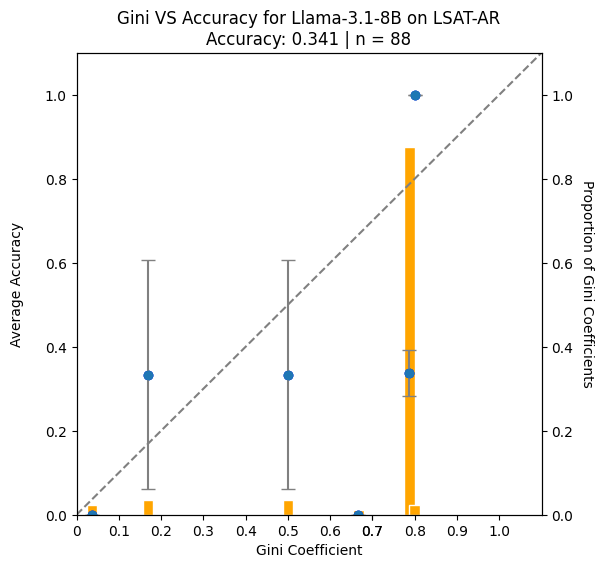

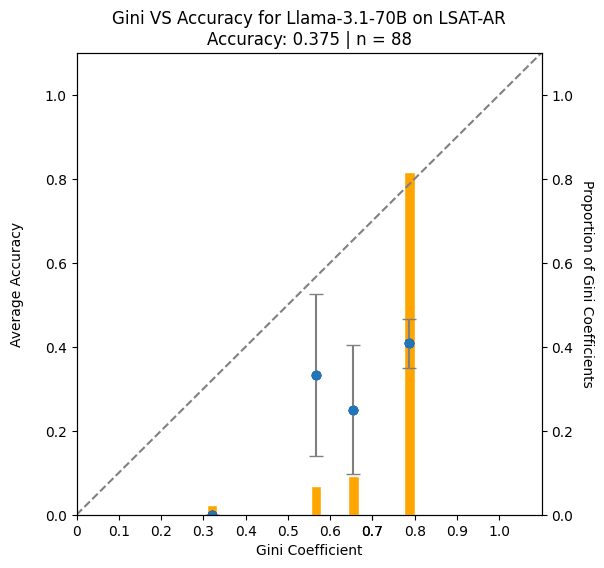

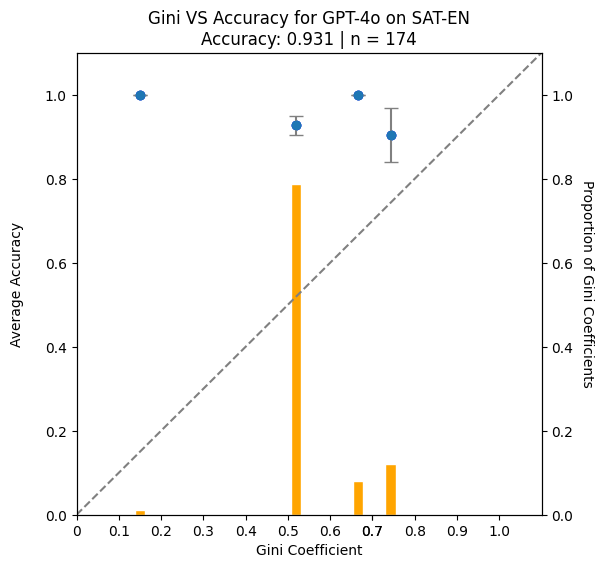

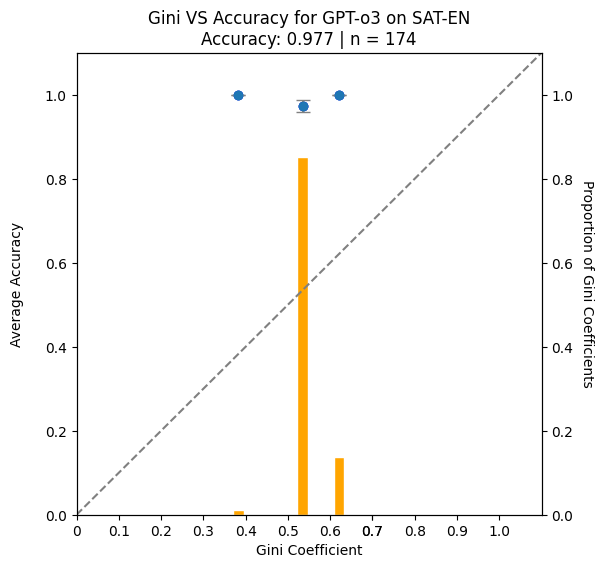

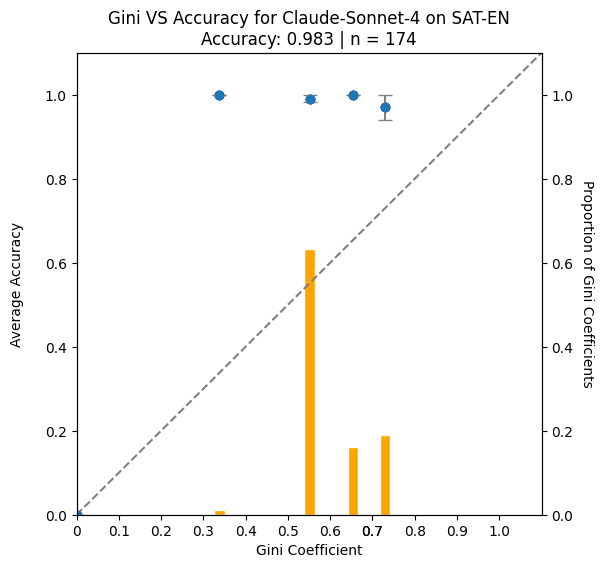

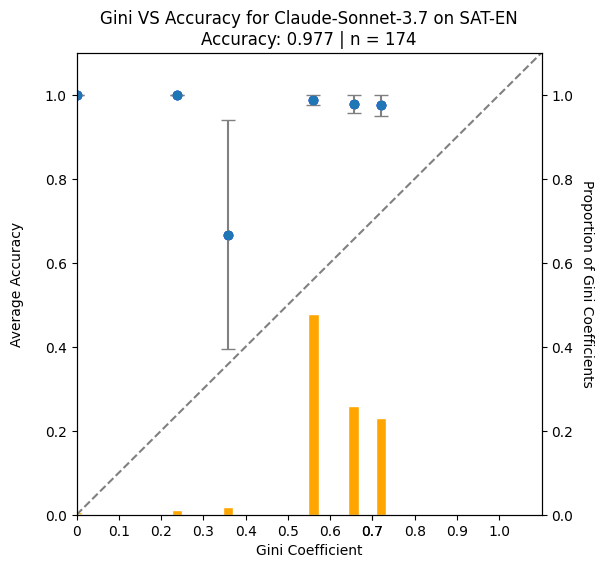

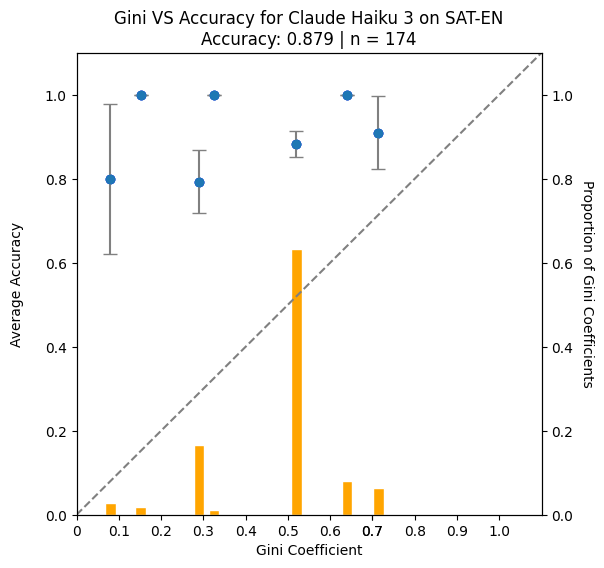

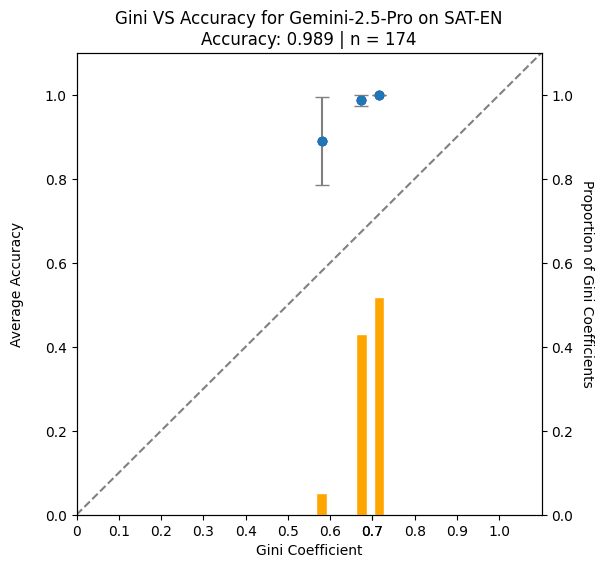

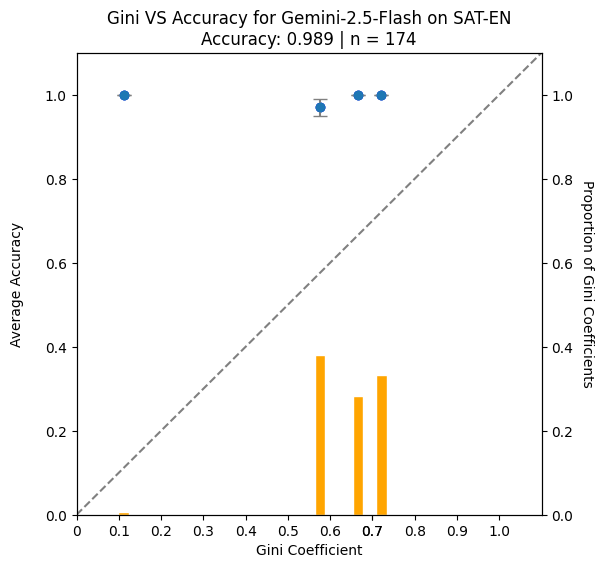

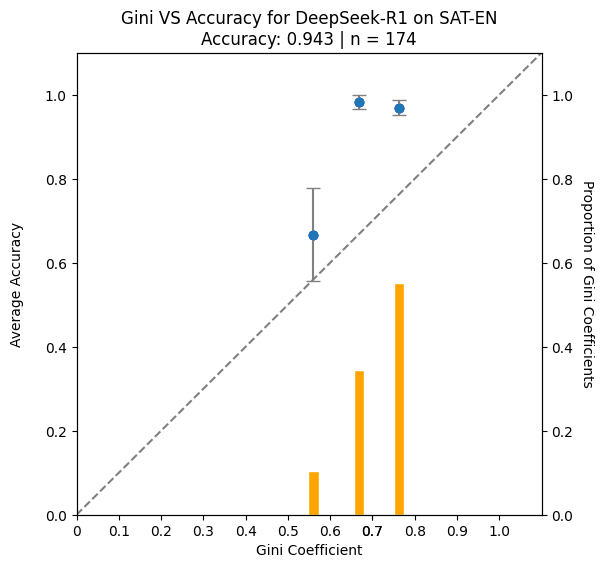

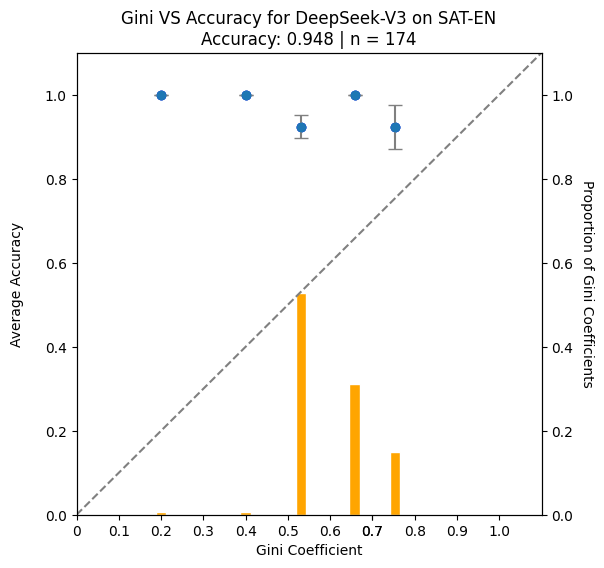

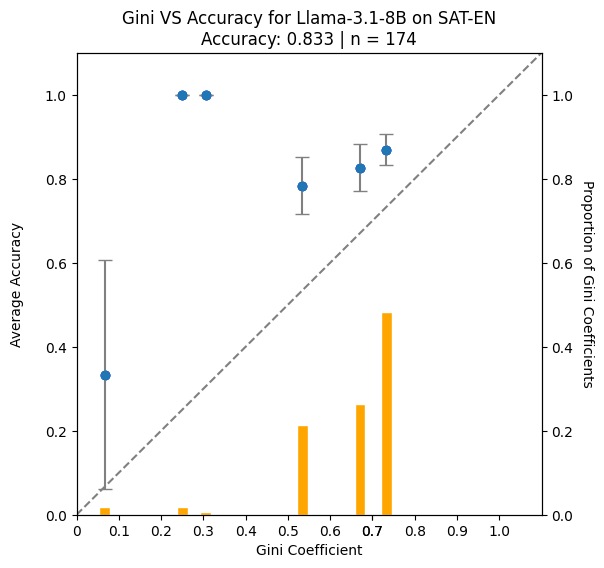

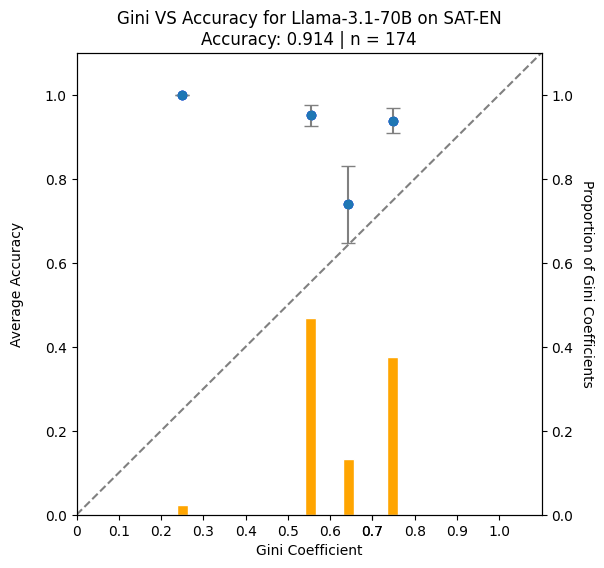

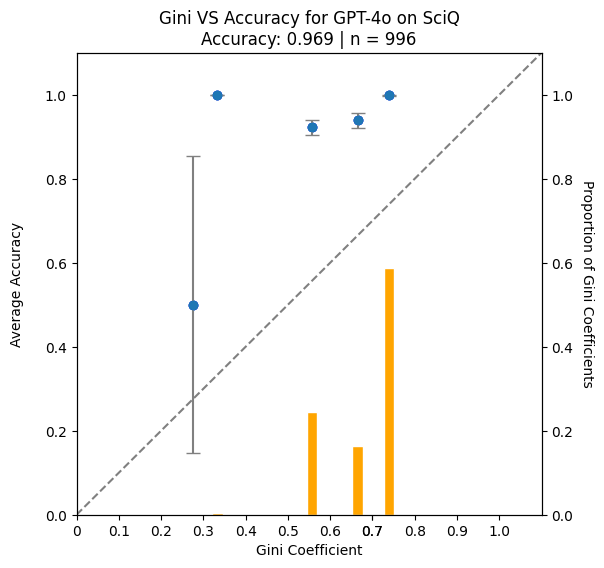

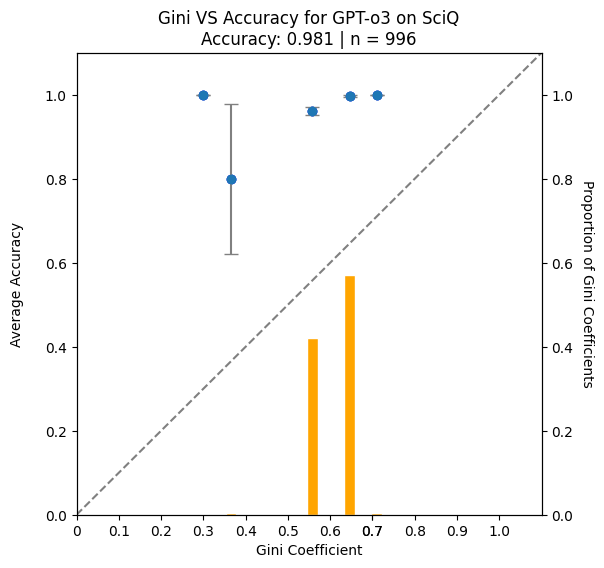

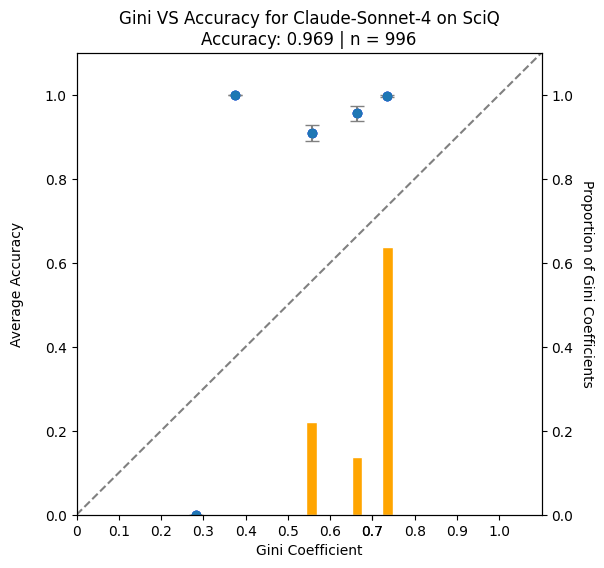

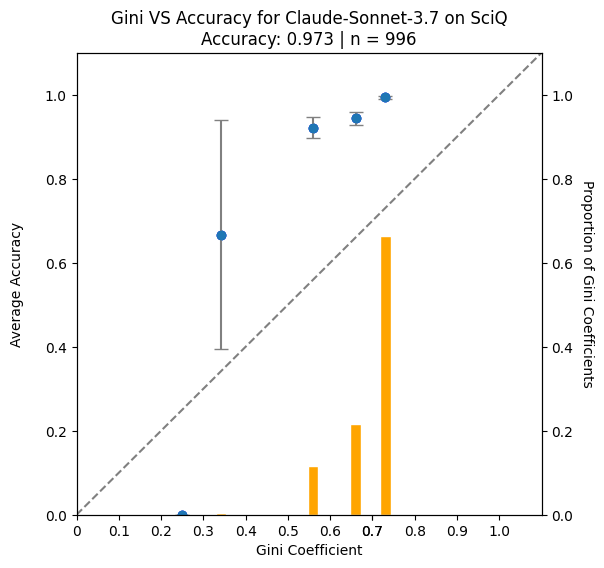

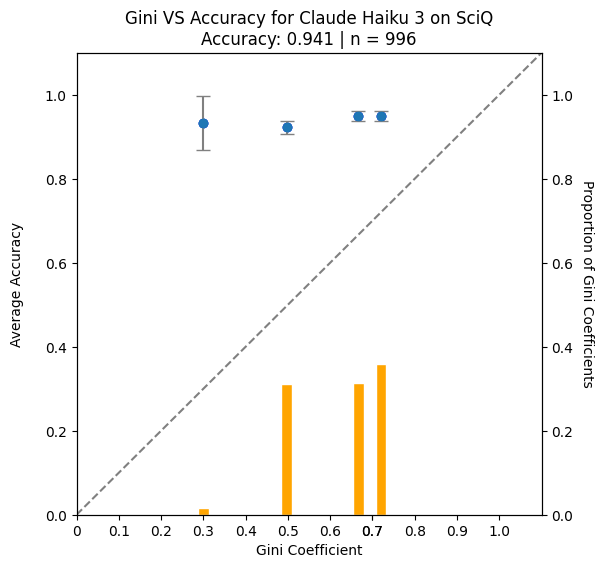

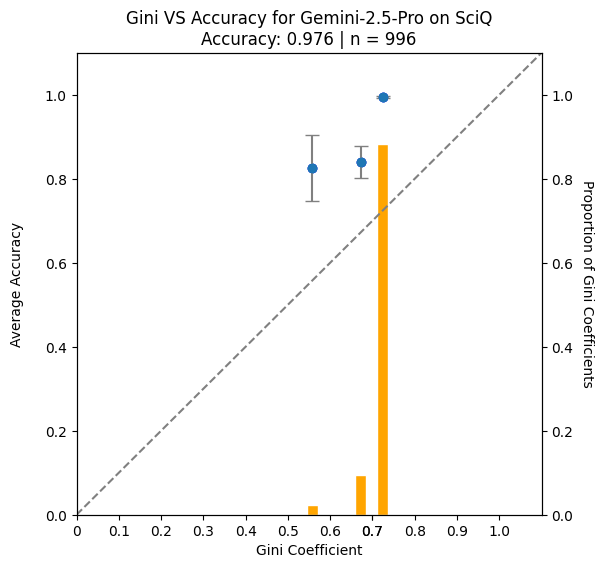

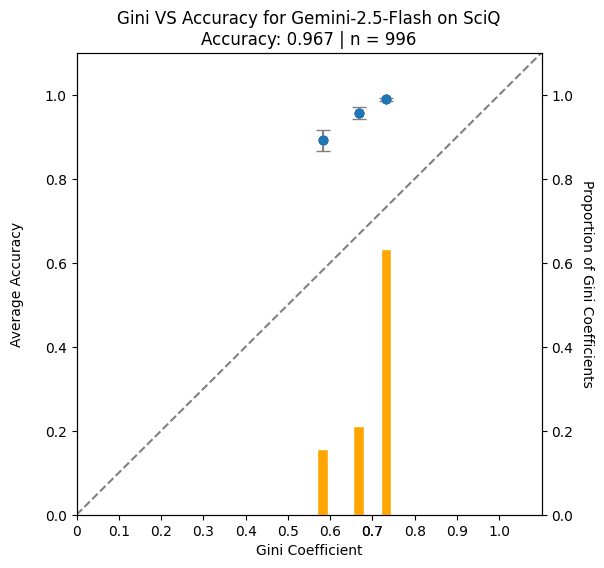

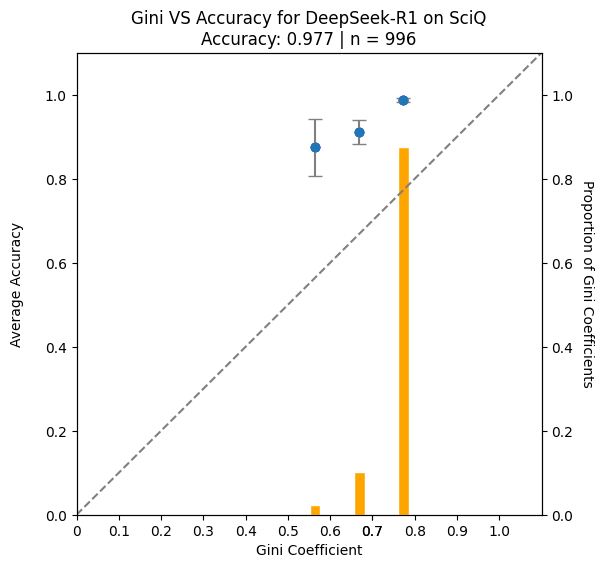

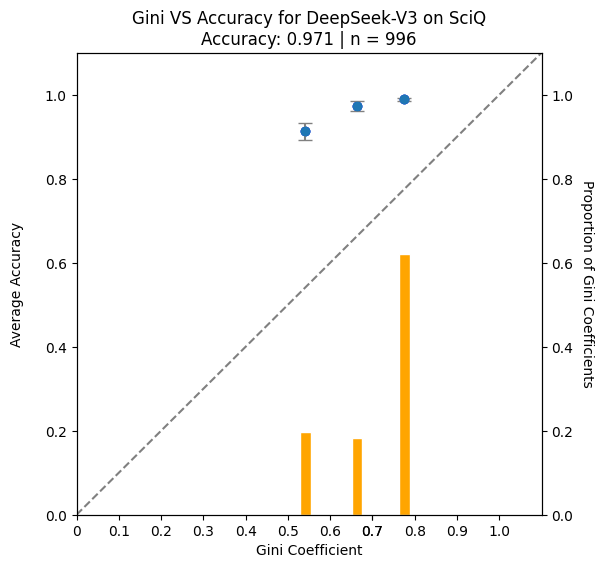

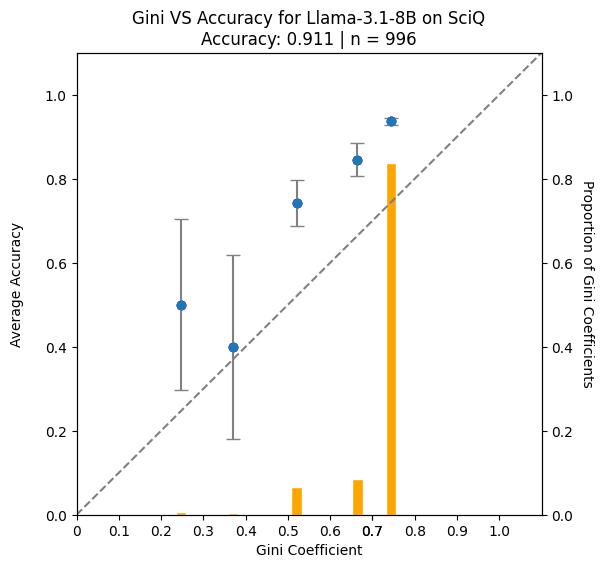

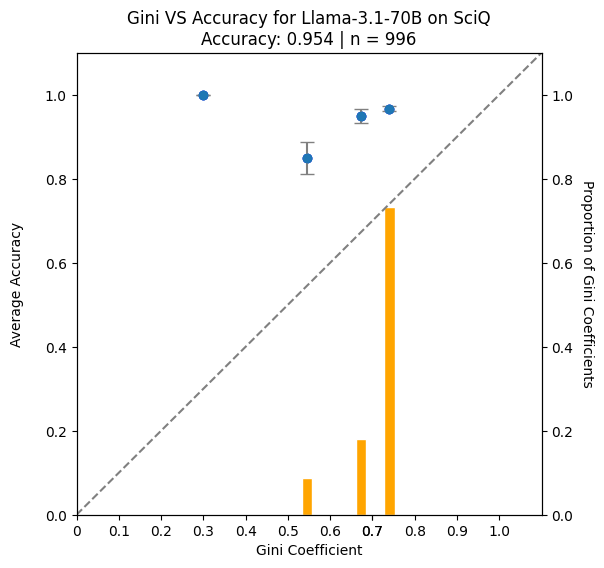

In [92]:
import time
def gini_plot(
        scores: pd.Series, 
        confidence: pd.Series, 
        n_bins: int = 10,
        model_name: str = '',
        qset_name: str = '',
        num_complete: int = None,
        title: str = None
        ):
    # Ensure inputs are numpy arrays
    scores = scores.astype(int).to_numpy()
    confidence = confidence.astype(float).to_numpy()
    
    # Calculate ECE and Accuracy
    ece = get_ece(pd.Series(scores), pd.Series(confidence), n_bins=n_bins)
    acc = np.mean(scores)

    melted = melt_series(score=scores, confidence=confidence)
    #display(melted)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))

    ## Line of Well Calibration
    ax.plot([0, 1.1], [0, 1.1], linestyle='--', color='grey')

    ## Histogram:
    ax.bar(
        melted['mean_confidence'].fillna(0), 
        melted['count'].fillna(0) / melted['count'].sum(), 
        width=0.025, 
        align='center', 
        edgecolor='white',
        color = 'orange'
        )
    ax.scatter(melted['mean_confidence'], melted['mean_score'])


    ## Error Bars:
    # Standard error for a proportion
    stderr = np.sqrt((melted['mean_score'] * (1 - melted['mean_score'])) / melted['count'])
    stderr = stderr.fillna(0)  # no error if count = 0 or NaN

    ax.errorbar(melted['mean_confidence'], 
                melted['mean_score'], 
                yerr = stderr,  
                fmt='o', 
                ecolor='grey', 
                capsize=5,
                #linestyle = 'none'
                )
    
    ax.scatter(melted['mean_confidence'], melted['mean_score'], color = 'blue')


    # 45-degree reference line


    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('Gini Coefficient')
    ax.set_ylabel('Average Accuracy', labelpad= 15)
    if title is not None:
        ax.set_title(f'Accuracy: {acc:.3f} | n = {num_complete}')
    else:
        ax.set_title(f'Gini VS Accuracy for {model_name} on {qset_name}\nAccuracy: {acc:.3f} | n = {num_complete}' )
    ticks = [0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7,0.7,0.8,0.9,1.0]
    labels = [0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7,0.7,0.8,0.9,1.0]
    ax.set_xticks(ticks= ticks, labels=labels)

    # Create a secondary y-axis for proportion
    ax2 = ax.twinx()
    ax.set_ylim(0, 1.1)
    ax2.set_ylabel('Proportion of Gini Coefficients',rotation=-90, labelpad= 15)

    ax.set_ylim(0, 1.1)
    ax2.set_ylim(0, 1.1)
    #ax.grid(False)   # turn off grid for left axis
    #ax2.grid(False)  # turn off grid for right axis
    plt.show()

    # # --- Save Plot ---
    # filename = f"gini_plot_{qset_key.lower()}_{model_key}.png"
    # out_path = output_dir / "Calibration Plots"  / filename  # assumes output_dir exists
    # fig.savefig(out_path, dpi=300, bbox_inches="tight")
    # plt.close(fig)

    
    #plt.tight_layout()
    #plt.show()

    return ece, acc


test_df = dfs['SciQ']['Claude Haiku 3']

for qset_name, qset_dict in dfs.items():
    if qset_name in mcq_qsets:
        for name, df in qset_dict.items():
            gini_plot(scores= df['Score'], confidence= df['Gini'], model_name= name, qset_name= qset_name, num_complete= len(df))
            #time.sleep(10)


## Token Calibration Plots:

In [ ]:
# Make special plots for LifeEval because of the many fields

<>:50: SyntaxWarning: invalid escape sequence '\S'
<>:50: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_21948\3428109920.py:50: SyntaxWarning: invalid escape sequence '\S'
  path = f'Plots\Summary Plots\\combined_cal_plot_llama_{version}B.png'


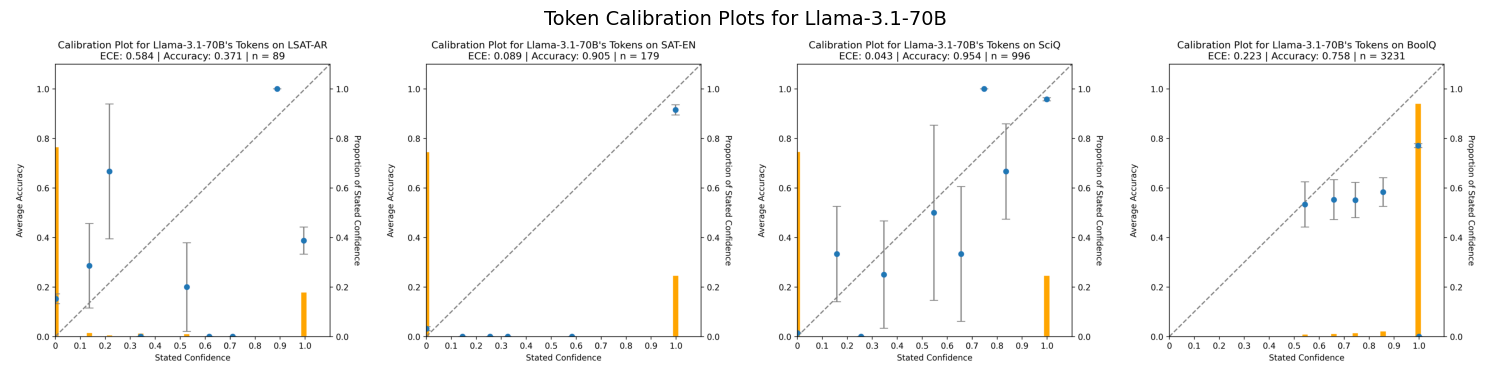

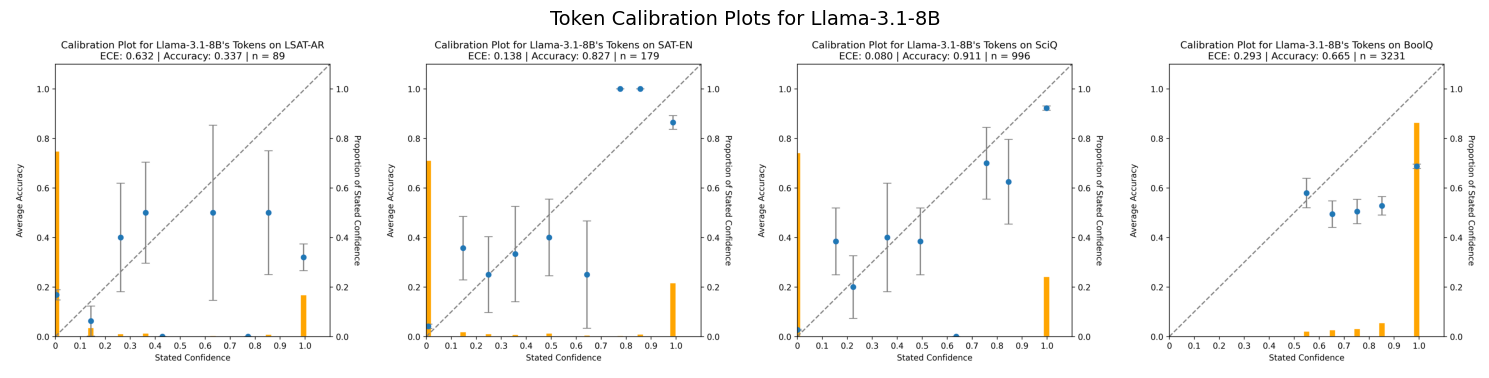

In [10]:
import matplotlib.image as mpimg



def side_by_side_plots(paths: tuple, title=  None):
    """
    Display three plots side by side given their file paths.

    Parameters
    ----------
    paths : tuple
        A tuple of three strings containing the file paths to the plots.
    """
    fig, axes = plt.subplots(1, len(paths), figsize=(15, 5))

    for ax, path in zip(axes, paths):
        img = mpimg.imread(path)
        ax.imshow(img)
        ax.axis("off")
    if title:
        fig.suptitle(title, fontsize=14, y = 0.85)
    plt.tight_layout()
    plt.show()

    return fig


llama_paths = (
    r'Plots\LSAT-AR\Calibration Plots\cal_plot_lsat_ar_test_Meta-Llama-3.1-70B-Instruct_tokens.png',
    r'Plots\SAT-EN\Calibration Plots\cal_plot_sat_en_Meta-Llama-3.1-70B-Instruct_tokens.png',
    r'Plots\SciQ\Calibration Plots\cal_plot_sciq_test_Meta-Llama-3.1-70B-Instruct_tokens.png',
    r'Plots\BoolQ\Calibration Plots\cal_plot_boolq_valid_Meta-Llama-3.1-70B-Instruct_tokens.png'
)

def plot_all(version = '70'):
    llama_paths = (
        r'Plots\LSAT-AR\Calibration Plots\cal_plot_lsat_ar_test_Meta-Llama-3.1-70B-Instruct_tokens.png',
        r'Plots\SAT-EN\Calibration Plots\cal_plot_sat_en_Meta-Llama-3.1-70B-Instruct_tokens.png',
        r'Plots\SciQ\Calibration Plots\cal_plot_sciq_test_Meta-Llama-3.1-70B-Instruct_tokens.png',
        r'Plots\BoolQ\Calibration Plots\cal_plot_boolq_valid_Meta-Llama-3.1-70B-Instruct_tokens.png'
    )

    llama_paths = tuple(x.replace("70", version) for x in llama_paths)
    
    title = 'Token Calibration Plots for Llama-3.1-70B'
    title = title.replace('70', version)

    fig = side_by_side_plots(llama_paths, title= title)

    path = f'Plots\\Summary Plots\\combined_cal_plot_llama_{version}B.png'
    fig.savefig(path, dpi=300, bbox_inches="tight")

plot_all('70')
plot_all('8')